In [1]:
import os
import io
# import cv2
import h5py
import math
import pydot
# import pickle
import warnings
import numpy as np
import pandas as pd
import seaborn as sns
from PIL import Image
import tensorflow as tf
import ipywidgets as widgets
from tensorflow import keras
import matplotlib.pyplot as plt
from IPython.display import display
from sklearn.decomposition import PCA
# from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix,f1_score,accuracy_score


%matplotlib inline
os.environ['KMP_DUPLICATE_LIB_OK']='True'
plt.rcParams['figure.figsize'] = (5.0, 4.0)
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'
warnings.filterwarnings('ignore')

np.random.seed(1)

# BUILDING BLOCKS OF ANN

### Initialization of Parameters

In [2]:

def initialize_parameters(layer_dims):

    np.random.seed(3)
    parameters = {}
     # number of layers in the network
    L = len(layer_dims)

    for l in range(1, L):

        # He initialization
        parameters['W' + str(l)] = np.random.randn(layer_dims[l], layer_dims[l-1]) * np.sqrt(2/layers_dims[l-1])
        parameters['b' + str(l)] = np.zeros((layer_dims[l], 1))


    return parameters


### Forward Propagation

In [3]:


def sigmoid(Z):

    A = 1/(1+np.exp(-Z))
    cache = Z

    return A, cache


In [4]:

def relu(Z):

    A = np.maximum(0,Z)

    cache = Z
    return A, cache


In [5]:

def linear_forward(A, W, b):


    Z = np.dot(W,A)+b
    cache = (A, W, b)

    return Z, cache


In [6]:

# def linear_activation_forward(A_prev, W, b, activation):

#     if activation == "sigmoid":

#         Z, linear_cache = linear_forward(A_prev, W, b)
#         A, activation_cache = sigmoid(Z)

#     elif activation == "relu":

#         Z, linear_cache = linear_forward(A_prev, W, b)
#         A, activation_cache = relu(Z)

#     cache = (linear_cache, activation_cache)

#     return A, cache

def linear_activation_forward(A_prev, W, b, activation, keep_prob = 1):

    if activation == "sigmoid":

        Z, linear_cache = linear_forward(A_prev, W, b)
        A, activation_cache = sigmoid(Z)

    elif activation == "relu":

        Z, linear_cache = linear_forward(A_prev, W, b)
        A, activation_cache = relu(Z)

    D = np.random.rand(A.shape[0],A.shape[1])
    D = (D < keep_prob).astype(int)
    A = np.multiply(A,D)
    A = A/keep_prob

    cache = (linear_cache, activation_cache, D, A)

    return A, cache


In [7]:

# def forward_propagation(X, parameters):

#     caches = []
#     A = X
#     L = len(parameters) // 2   # number of layers in the neural network

#     for l in range(1, L):

#         A_prev = A
#         A, cache = linear_activation_forward(A, parameters['W'+str(l)], parameters['b'+str(l)], 'relu')
#         caches.append(cache)

#     AL, cache = linear_activation_forward(A, parameters['W'+str(L)], parameters['b'+str(L)], 'sigmoid')
#     caches.append(cache)

#     return AL, caches

def forward_propagation(X, parameters, keep_prob = 1):

    caches = []
    A = X
    L = len(parameters) // 2   # number of layers in the neural network

    for l in range(1, L):

        A_prev = A
        A, cache = linear_activation_forward(A, parameters['W'+str(l)], parameters['b'+str(l)], 'relu',keep_prob)
        caches.append(cache)

    AL, cache = linear_activation_forward(A, parameters['W'+str(L)], parameters['b'+str(L)], 'sigmoid')
    caches.append(cache)

    return AL, caches

### Computing Cost

In [8]:

def compute_cost(AL, Y):

    m = Y.shape[1]
    cost = -np.sum(np.multiply(Y,np.log(AL))+np.multiply((1-Y),np.log((1-AL))))/m
    cost = np.squeeze(cost)   # this turns [[17]] into 17.

    return cost


### Back Propagation

In [9]:

# def linear_backward(dZ, cache):

#     A_prev, W, b = cache
#     m = A_prev.shape[1]

#     dW = np.dot(dZ,A_prev.T)/m
#     db = np.sum(dZ,keepdims=True,axis=1)/m
#     dA_prev = np.dot(W.T,dZ)

#     return dA_prev, dW, db


# def linear_backward(dZ, cache, lambd = 0):

#     A_prev, W, b = cache
#     m = A_prev.shape[1]

#     dW = 1./m * np.dot(dZ,A_prev.T) + lambd*W/m
#     db = np.sum(dZ,keepdims=True,axis=1)/m
#     dA_prev = np.dot(W.T,dZ)

#     return dA_prev, dW, db

def linear_backward(dZ, cache, lambd = 0,keep_prob = 1):

    A_prev, W, b = cache
    m = A_prev.shape[1]

    dW = 1./m * np.dot(dZ,A_prev.T) + lambd*W/m
    db = np.sum(dZ,keepdims=True,axis=1)/m

    dA_prev = np.dot(W.T,dZ)

    return dA_prev, dW, db



In [10]:

def sigmoid_backward(dA, cache):

    Z = cache

    s = 1/(1+np.exp(-Z))
    dZ = dA * s * (1-s)

    return dZ


In [11]:

def relu_backward(dA, cache):

    Z = cache
    dZ = np.array(dA, copy=True) # just converting dz to a correct object.

    dZ[Z <= 0] = 0

    return dZ


In [12]:

# def linear_activation_backward(dA, cache, activation):

#     linear_cache, activation_cache = cache

#     if activation == "relu":

#         dZ =  relu_backward(dA, activation_cache)
#         dA_prev, dW, db = linear_backward(dZ, linear_cache)

#     elif activation == "sigmoid":

#         dZ = sigmoid_backward(dA, activation_cache)
#         dA_prev, dW, db = linear_backward(dZ, linear_cache)

#     return dA_prev, dW, db


# def linear_activation_backward(dA, cache, activation,lambd = 0):

#     linear_cache, activation_cache = cache

#     if activation == "relu":

#         dZ =  relu_backward(dA, activation_cache)
#         dA_prev, dW, db = linear_backward(dZ, linear_cache,lambd)

#     elif activation == "sigmoid":

#         dZ = sigmoid_backward(dA, activation_cache)
#         dA_prev, dW, db = linear_backward(dZ, linear_cache,lambd)

#     return dA_prev, dW, db

def linear_activation_backward(dA, cache, activation,lambd = 0,keep_prob=1,req_D = 1):

    linear_cache, activation_cache, D, A = cache

    if activation == "relu":

        dZ =  relu_backward(dA, activation_cache)
        dZ = np.multiply(dA, np.int64(A > 0))
        dA_prev, dW, db = linear_backward(dZ, linear_cache, lambd, keep_prob)
        dA_prev = np.multiply(dA_prev,req_D)
        dA_prev = dA_prev/keep_prob

    elif activation == "sigmoid":

        dZ = sigmoid_backward(dA, activation_cache)
        dA_prev, dW, db = linear_backward(dZ, linear_cache, lambd)

    return dA_prev, dW, db


In [13]:

# def backward_propagation(AL, Y, caches):

#     grads = {}
#     L = len(caches) # the number of layers
#     m = AL.shape[1]
#     Y = Y.reshape(AL.shape) # after this line, Y is the same shape as AL

#     dAL = - (np.divide(Y, AL) - np.divide(1 - Y, 1 - AL))

#     current_cache = caches[L-1]
#     dA_prev_temp, dW_temp, db_temp = linear_activation_backward(dAL, current_cache, 'sigmoid')
#     grads["dA" + str(L-1)] = dA_prev_temp
#     grads["dW" + str(L)] = dW_temp
#     grads["db" + str(L)] = db_temp

#     for l in reversed(range(L-1)):

#         current_cache = caches[l]
#         dA_prev_temp, dW_temp, db_temp = linear_activation_backward(grads["dA" + str(l + 1)], current_cache, 'relu')
#         grads["dA" + str(l)] = dA_prev_temp
#         grads["dW" + str(l+1)] = dW_temp
#         grads["db" + str(l+1)] = db_temp

#     return grads


# def backward_propagation(AL, Y, caches, lambd = 0):

#     grads = {}
#     L = len(caches) # the number of layers
#     m = AL.shape[1]
#     Y = Y.reshape(AL.shape) # after this line, Y is the same shape as AL

#     dAL = - (np.divide(Y, AL) - np.divide(1 - Y, 1 - AL))

#     current_cache = caches[L-1]
#     dA_prev_temp, dW_temp, db_temp = linear_activation_backward(dAL, current_cache, 'sigmoid',lambd)
#     grads["dA" + str(L-1)] = dA_prev_temp
#     grads["dW" + str(L)] = dW_temp
#     grads["db" + str(L)] = db_temp

#     for l in reversed(range(L-1)):

#         current_cache = caches[l]
#         dA_prev_temp, dW_temp, db_temp = linear_activation_backward(grads["dA" + str(l + 1)], current_cache, 'relu',lambd)
#         grads["dA" + str(l)] = dA_prev_temp
#         grads["dW" + str(l+1)] = dW_temp
#         grads["db" + str(l+1)] = db_temp

#     return grads

def backward_propagation(AL, Y, caches, lambd = 0,keep_prob = 1):

    grads = {}
    L = len(caches) # the number of layers
    m = AL.shape[1]
    Y = Y.reshape(AL.shape) # after this line, Y is the same shape as AL

    dAL = - (np.divide(Y, AL) - np.divide(1 - Y, 1 - AL))

    current_cache = caches[L-1]
    dA_prev_temp, dW_temp, db_temp = linear_activation_backward(dAL, current_cache, 'sigmoid',lambd)
    grads["dA" + str(L-1)] = dA_prev_temp
    grads["dW" + str(L)] = dW_temp
    grads["db" + str(L)] = db_temp

    for l in reversed(range(L-1)):

        current_cache = caches[l]
        try:
            req_D = caches[l-1][2]
        except:
            req_D = 1
        dA_prev_temp, dW_temp, db_temp = linear_activation_backward(grads["dA" + str(l + 1)], current_cache, 'relu',lambd,keep_prob,req_D)
        grads["dA" + str(l)] = dA_prev_temp
        grads["dW" + str(l+1)] = dW_temp
        grads["db" + str(l+1)] = db_temp

    return grads



### Update Parameters

In [14]:

def update_parameters(params, grads, learning_rate):

    parameters = params.copy()
    L = len(parameters) // 2 # number of layers in the neural network

    for l in range(L):

        parameters["W" + str(l+1)] = parameters["W" + str(l+1)] - learning_rate * grads["dW" + str(l+1)]
        parameters["b" + str(l+1)] = parameters["b" + str(l+1)] - learning_rate * grads["db" + str(l+1)]

    return parameters


### Model Definition # 01

In [15]:

def build_model(X, Y, layers_dims, learning_rate = 0.0075, num_iterations = 3000):

    np.random.seed(1)
    costs = []   # keep track of cost
#     accuracies = []
#     m = X.shape[1]

    parameters = initialize_parameters(layers_dims)

    for i in range(0, num_iterations):

        AL, caches = forward_propagation(X, parameters)

#         p = np.zeros((1,m))
#         p[AL>0.5] = 1
#         accuracy = np.squeeze(np.sum((p == Y)/m))

        cost = compute_cost(AL, Y)
        costs.append(cost)

        grads = backward_propagation(AL, Y, caches)

        parameters = update_parameters(parameters, grads, learning_rate)

        if i % 100 == 0 or i == num_iterations - 1:
            print("Cost after iteration {}: {}".format(i, np.squeeze(cost)))
            print('Train',end=' ')
            predict(X, Y, parameters, 0.5)
            print('Test',end=' ')
            predict(X_test, y_test, parameters, 0.5)
#             accuracies.append(accuracy)

    return parameters, costs


### Prediction

In [16]:

def predict(X, y, parameters, threshold):

    m = X.shape[1]
    n = len(parameters) // 2
    p = np.zeros((1,m))

    probas, caches = forward_propagation(X, parameters)


    # convert probas to 0/1 predictions
    for i in range(0, probas.shape[1]):
        if probas[0,i] > threshold:
            p[0,i] = 1
        else:
            p[0,i] = 0
    acc = round(np.sum((p == y)/m)*100,2)
    print("Accuracy: "  + str(acc))

    return p,acc

### Some Important Functions

In [17]:
def plot_costs(costs, learning_rate=0.0075):

    plt.plot(np.squeeze(costs))
    plt.ylabel('cost')
    plt.xlabel('iterations (per hundreds)')
    plt.title("Learning rate =" + str(learning_rate))
    plt.grid()
    plt.show()


In [18]:
def save_model(name, costs, parameters): # {'cost':costs,'train_accuracy':train_acc,'test_accuracy':test_acc}
    model = costs
    for i in parameters:
        parameters[i] = parameters[i].tolist()
    model['parameters'] = parameters
    with open(name,'w') as f:
        f.write(str(model))

In [19]:
def load_model(name):
    with open(name,'r') as f:
        model = eval(f.read())
    for i in model['parameters']:
        model['parameters'][i] = np.array(model['parameters'][i])
    return model['parameters'],model['cost'],model['train_accuracy'],model["test_accuracy"]

In [20]:
def showImage(images,title):
    plt.figure(figsize=(10, 10))
    for i in range(25):
        ax = plt.subplot(5, 5, i + 1)
        index = np.random.randint(50000)
        plt.imshow(images[index])
        plt.title(title[index])
        plt.axis("off")

In [21]:
class Model:
    
    def __init__(self,name,acc,f1):
        self.name = name
        self.acc = acc
        self.f1 = f1

In [22]:
def plot_confusion_Matrix(parameters,lst,name,X,y):
    pr, tr_acc = predict(X, y, parameters, 0.5)
    f1 = f1_score(y.T,pr.T)
    sns.heatmap(confusion_matrix(y.T,pr.T),annot=True)
    lst.append(Model(name,tr_acc,f1))
    print('F1 score:',f1)

In [23]:
def drawTable(ls1, ls2):
    return pd.DataFrame({
    'Model Name':[i.name for i in ls1],
    'Training Accuracy':[i.acc for i in ls1],
    'Train F1 Score':[round(i.f1*100,2) for i in ls1],
    'Test Accuracy':[i.acc for i in ls2],
    'Test F1 Score':[round(i.f1*100,2) for i in ls2],
}).set_index('Model Name')

# Load Dataset

In [24]:
(X_train, y_train), (X_test, y_test) = tf.keras.datasets.cifar10.load_data()

# Preprocessing

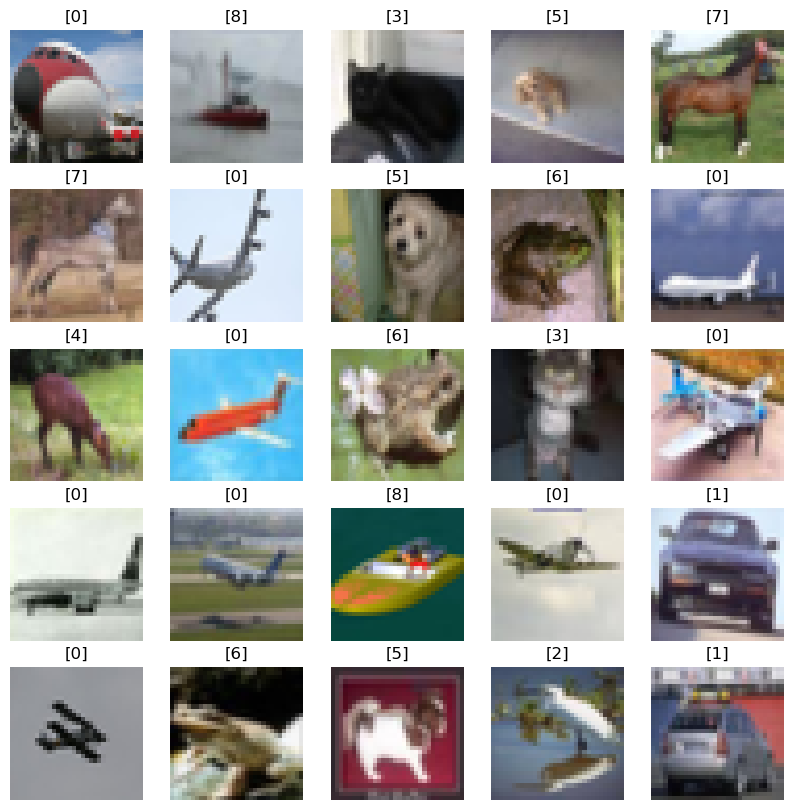

In [25]:
showImage(X_train,y_train)

#### Relabeling

In [26]:
def to_binary(x):

    if x in [0,1,8,9]:
        #vehicle
        return 0
    else:
      #animal
        return 1

to_binary = np.vectorize(to_binary)

In [27]:
y_train = to_binary(y_train)
y_test = to_binary(y_test)

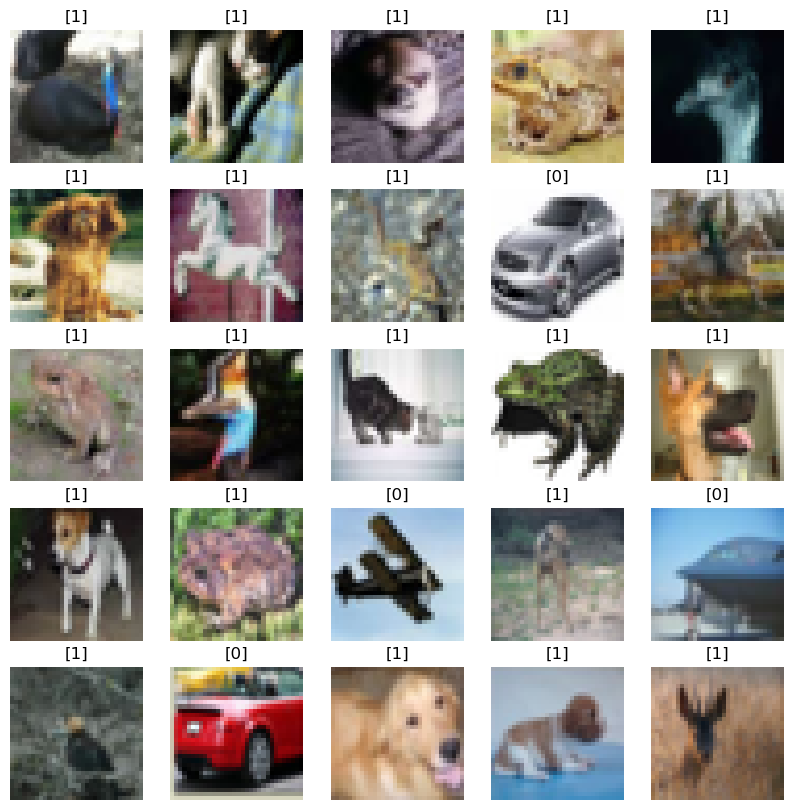

In [28]:
showImage(X_train,y_train)

In [29]:
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(50000, 32, 32, 3)
(10000, 32, 32, 3)
(50000, 1)
(10000, 1)


#### Flattening

In [30]:
X_train_ = X_train.reshape(X_train.shape[0],-1).T
X_test_ = X_test.reshape(X_test.shape[0],-1).T
y_train = y_train.T
y_test = y_test.T

In [31]:
print(X_train_.shape)
print(X_test_.shape)
print(y_train.shape)
print(y_test.shape)

(3072, 50000)
(3072, 10000)
(1, 50000)
(1, 10000)


#### Scaling

In [32]:
X_train_s = X_train_/255.
X_test_s = X_test_/255.

model_tr_acc = []
model_ts_acc = []


#### 3 channels to 1 channel for shallow Algo

In [33]:
def rgb2gray(rgb):
    return np.dot(rgb[...,:3], [0.2989, 0.5870, 0.1140])

In [34]:
X_train_g = rgb2gray(X_train)
X_test_g = rgb2gray(X_test)

In [35]:
print(X_train_g.shape)
print(X_test_g.shape)

(50000, 32, 32)
(10000, 32, 32)


In [36]:
X_train_g = X_train_g.reshape(X_train.shape[0],-1).T
X_test_g = X_test_g.reshape(X_test.shape[0],-1).T

In [37]:
print(X_train_g.shape)
print(X_test_g.shape)

(1024, 50000)
(1024, 10000)


In [38]:
X_train_g = X_train_g/255.
X_test_g = X_test_g/255.

## Train Batch Model

- Memory Error

## Define Mini Batches

In [39]:

def random_mini_batches(X, Y, mini_batch_size = 64, seed = 0):

    np.random.seed(seed)
    m = X.shape[1]           # number of training examples
    mini_batches = []

    # Shuffle (X, Y)
    permutation = list(np.random.permutation(m))
    shuffled_X = X[:, permutation]
    shuffled_Y = Y[:, permutation].reshape((1, m))

    inc = mini_batch_size

    num_complete_minibatches = math.floor(m / mini_batch_size)
    for k in range(0, num_complete_minibatches):

        mini_batch_X =  shuffled_X[:,inc*k:inc*(k+1)]
        mini_batch_Y =  shuffled_Y[:,inc*k:inc*(k+1)]

        mini_batch = (mini_batch_X, mini_batch_Y)
        mini_batches.append(mini_batch)

    if m % mini_batch_size != 0:

        mini_batch_X =  shuffled_X[:,mini_batch_size*num_complete_minibatches:m]
        mini_batch_Y =  shuffled_Y[:,mini_batch_size*num_complete_minibatches:m]

        mini_batch = (mini_batch_X, mini_batch_Y)
        mini_batches.append(mini_batch)

    return mini_batches

### Model Definition # 02

In [40]:
def build_model_mb(X, Y, layers_dims, learning_rate = 0.0007, mini_batch_size = 64, num_epochs = 5000, print_cost = True):


    L = len(layers_dims)             # number of layers in the neural networks
    costs = []                       # to keep track of the cost
    m = X.shape[1]                   # number of training examples
    seed = 10
    train_acc = []
    test_acc = []
    # Initialize parameters
    parameters = initialize_parameters(layers_dims)

    # Optimization loop
    for i in range(num_epochs):

        # Define the random minibatches. We increment the seed to reshuffle differently the dataset after each epoch
        seed = seed + 1
        minibatches = random_mini_batches(X, Y, mini_batch_size, seed)
        cost_total = 0

        for minibatch in minibatches:

            # Select a minibatch
            (minibatch_X, minibatch_Y) = minibatch

            # Forward propagation
            al, caches = forward_propagation(minibatch_X, parameters)

            # Compute cost and add to the cost total
            cost_total += compute_cost(al, minibatch_Y)

            # Backward propagation
            grads = backward_propagation(al, minibatch_Y, caches)

            # Update parameters
            parameters = update_parameters(parameters, grads, learning_rate)

        cost_avg = cost_total / m
        costs.append(cost_avg)

        print ("Cost after epoch %i: %f" %(i, cost_avg))
        print('Train',end=' ')
        _, tr_acc = predict(X, Y, parameters, 0.5)
        print('Test',end=' ')
        _, ts_acc = predict(X_test, y_test, parameters, 0.5)
        train_acc.append(tr_acc)
        test_acc.append(ts_acc)
    acc_cost = {'cost':costs,'train_accuracy':train_acc,'test_accuracy':test_acc}
    return parameters,acc_cost


### Model # 01

In [41]:
m1_parameters, m1_costs, m1_train_accuracy, m1_test_accuracy = load_model('model_1')

Accuracy: 92.35
F1 score: 0.9362821836591947


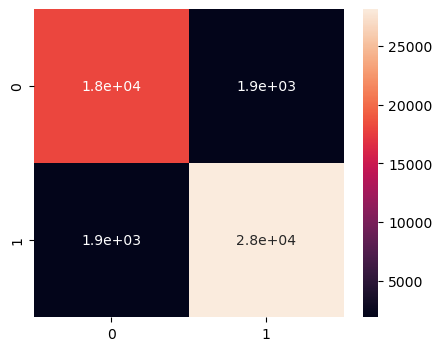

In [42]:
plot_confusion_Matrix(m1_parameters,model_tr_acc,'model-1',X_train_s,y_train)

Accuracy: 87.6
F1 score: 0.8962863834058213


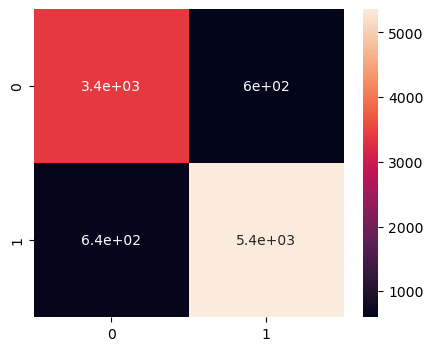

In [43]:
plot_confusion_Matrix(m1_parameters,model_ts_acc,'model-1',X_test_s,y_test)

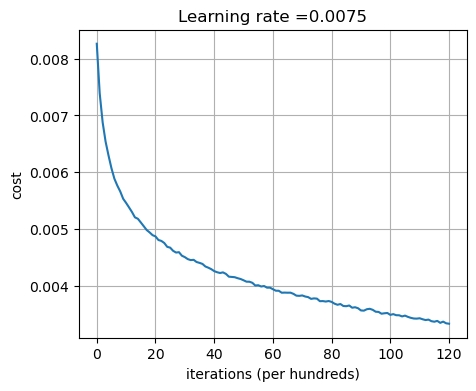

In [44]:
plot_costs(m1_costs)

### Model # 02

In [45]:
m2_parameters, m2_costs, m2_train_accuracy, m2_test_accuracy = load_model('model_2')

Accuracy: 93.54
F1 score: 0.9452992611672203


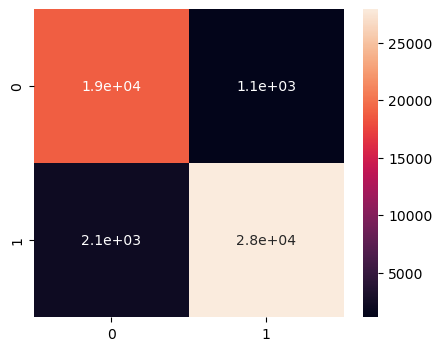

In [46]:
plot_confusion_Matrix(m2_parameters,model_tr_acc,'model-2',X_train_s,y_train)

Accuracy: 87.49
F1 score: 0.8942608401656665


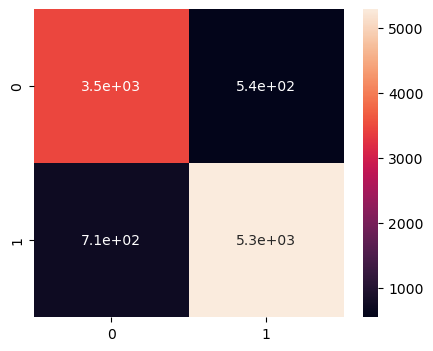

In [47]:
plot_confusion_Matrix(m2_parameters,model_ts_acc,'model-2',X_test_s,y_test)

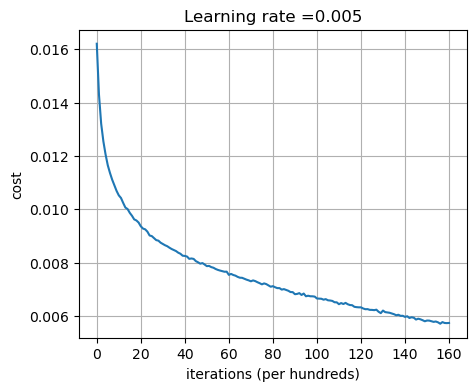

In [48]:
plot_costs(m2_costs,learning_rate=0.005)

### Model # 03

In [49]:
m3_parameters, m3_costs, m3_train_accuracy, m3_test_accuracy = load_model('model_3')

Accuracy: 93.06
F1 score: 0.9421633701344184


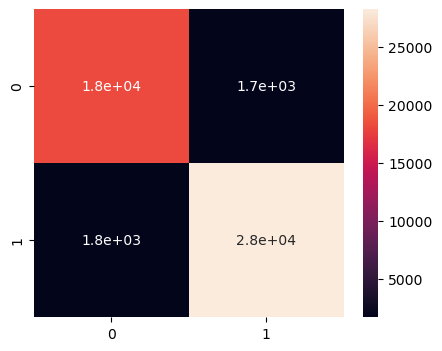

In [50]:
plot_confusion_Matrix(m3_parameters,model_tr_acc,'model-3',X_train_s,y_train)

Accuracy: 87.05
F1 score: 0.8914774155702673


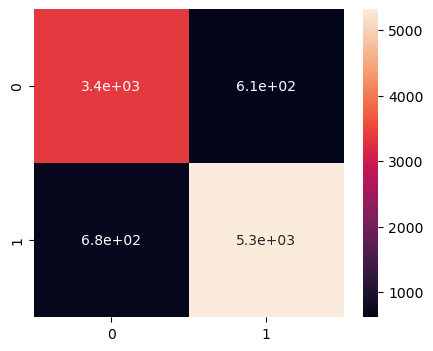

In [51]:
plot_confusion_Matrix(m3_parameters,model_ts_acc,'model-3',X_test_s,y_test)

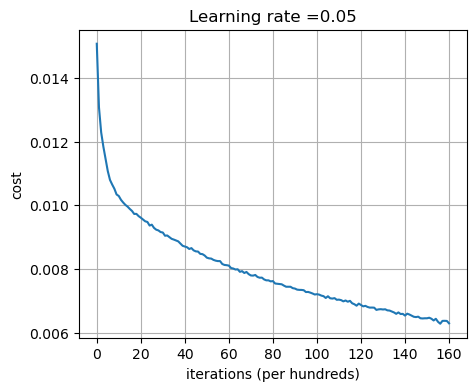

In [52]:
plot_costs(m3_costs,learning_rate=0.05)

# Lets add Some optimizers

In [53]:

def initialize_velocity(parameters):

    L = len(parameters) // 2 # number of layers in the neural networks
    v = {}

    # Initialize velocity
    for l in range(1, L + 1):

        v["dW" + str(l)] = np.zeros(parameters["W" + str(l)].shape)
        v["db" + str(l)] = np.zeros(parameters["b" + str(l)].shape)

    return v


In [54]:

def update_parameters_with_momentum(parameters, grads, v, beta, learning_rate):

    L = len(parameters) // 2 # number of layers in the neural networks

    # Momentum update for each parameter
    for l in range(1, L + 1):

        v["dW" + str(l)] = beta*v["dW" + str(l)] + (1-beta)*grads["dW" + str(l)]
        v["db" + str(l)] = beta*v["db" + str(l)] + (1-beta)*grads["db" + str(l)]
        parameters["W" + str(l)] = parameters["W" + str(l)] - learning_rate*v["dW" + str(l)]
        parameters["b" + str(l)] = parameters["b" + str(l)] - learning_rate*v["db" + str(l)]

    return parameters, v

In [55]:

def initialize_adam(parameters) :

    L = len(parameters) // 2
    v = {}
    s = {}

    # Initialize v, s.
    for l in range(1, L + 1):

        v["dW" + str(l)] = np.zeros(parameters["W" + str(l)].shape)
        v["db" + str(l)] = np.zeros(parameters["b" + str(l)].shape)
        s["dW" + str(l)] = np.zeros(parameters["W" + str(l)].shape)
        s["db" + str(l)] = np.zeros(parameters["b" + str(l)].shape)

    return v, s


In [56]:

def update_parameters_with_adam(parameters, grads, v, s, t, learning_rate = 0.01,
                                beta1 = 0.9, beta2 = 0.999,  epsilon = 1e-8):


    L = len(parameters) // 2
    v_corrected = {}
    s_corrected = {}

    # Perform Adam update on all parameters
    for l in range(1, L + 1):

        v["dW" + str(l)] = beta1*v["dW" + str(l)] + (1-beta1)*grads["dW" + str(l)]
        v["db" + str(l)] = beta1*v["db" + str(l)] + (1-beta1)*grads["db" + str(l)]

        v_corrected["dW" + str(l)] = v["dW" + str(l)]/(1 - math.pow(beta1,t))
        v_corrected["db" + str(l)] = v["db" + str(l)]/(1 - math.pow(beta1,t))


        s["dW" + str(l)] = beta2*s["dW" + str(l)] + (1-beta2)*grads["dW" + str(l)]*grads["dW" + str(l)]
        s["db" + str(l)] = beta2*s["db" + str(l)] + (1-beta2)*grads["db" + str(l)]*grads["db" + str(l)]


        s_corrected["dW" + str(l)] = s["dW" + str(l)]/(1 - math.pow(beta2,t))
        s_corrected["db" + str(l)] = s["db" + str(l)]/(1 - math.pow(beta2,t))


        parameters["W" + str(l)] = parameters["W" + str(l)] - learning_rate*np.divide(v_corrected["dW" + str(l)],np.sqrt(s_corrected["dW" + str(l)])+epsilon)
        parameters["b" + str(l)] = parameters["b" + str(l)] - learning_rate*np.divide(v_corrected["db" + str(l)],np.sqrt(s_corrected["db" + str(l)])+epsilon)

    return parameters, v, s


### Model Definition # 03

In [57]:
def build_model_with_optimizer(X, Y, layers_dims, optimizer, learning_rate = 0.0007, mini_batch_size = 64, beta = 0.9,
          beta1 = 0.9, beta2 = 0.999,  epsilon = 1e-8, num_epochs = 5000, print_cost = True):

    L = len(layers_dims)
    costs = []
    t = 0
    seed = 10
    m = X.shape[1]
    train_acc = []
    test_acc = []
    parameters = initialize_parameters(layers_dims)

    # Initialize the optimizer
    if optimizer == "gd":
        pass # no initialization required for gradient descent
    elif optimizer == "momentum":
        v = initialize_velocity(parameters)
    elif optimizer == "adam":
        v, s = initialize_adam(parameters)

    for i in range(num_epochs):

        seed = seed + 1
        minibatches = random_mini_batches(X, Y, mini_batch_size, seed)
        cost_total = 0

        for minibatch in minibatches:

            # Select a minibatch
            (minibatch_X, minibatch_Y) = minibatch

            # Forward propagation
            al, caches = forward_propagation(minibatch_X, parameters)

            # Compute cost and add to the cost total
            cost_total += compute_cost(al, minibatch_Y)

            # Backward propagation
            grads = backward_propagation(al, minibatch_Y, caches)

            # Update parameters
            if optimizer == "gd":
                parameters = update_parameters(parameters, grads, learning_rate)
            elif optimizer == "momentum":
                parameters, v = update_parameters_with_momentum(parameters, grads, v, beta, learning_rate)
            elif optimizer == "adam":
                t = t + 1  # Adam counter
                parameters, v, s = update_parameters_with_adam(parameters, grads, v, s,
                                                               t, learning_rate, beta1, beta2,  epsilon)
        cost_avg = cost_total / m
        costs.append(cost_avg)

        print ("Cost after epoch %i: %f" %(i, cost_avg))
        print('Train',end=' ')
        _, tr_acc = predict(X, Y, parameters, 0.5)
        print('Test',end=' ')
        _, ts_acc = predict(X_test, y_test, parameters, 0.5)
        train_acc.append(tr_acc)
        test_acc.append(ts_acc)

    acc_cost = {'cost':costs,'train_accuracy':train_acc,'test_accuracy':test_acc}

    return parameters,acc_cost


### Model # 04

In [58]:
m4_parameters, m4_costs, m4_train_accuracy, m4_test_accuracy = load_model('model_4')

Accuracy: 88.77
F1 score: 0.9072444143534191


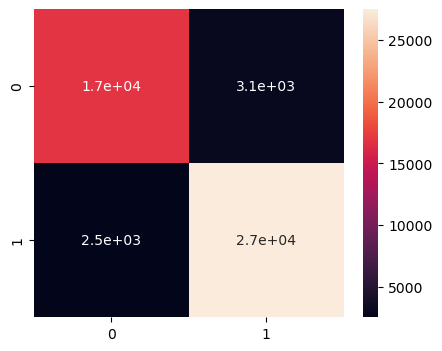

In [59]:
plot_confusion_Matrix(m4_parameters,model_tr_acc,'model-4',X_train_s,y_train)

Accuracy: 86.1
F1 score: 0.8858784893267653


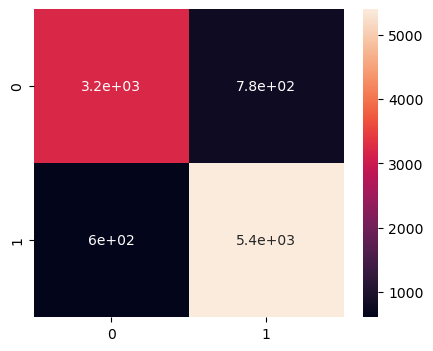

In [60]:
plot_confusion_Matrix(m4_parameters,model_ts_acc,'model-4',X_test_s,y_test)

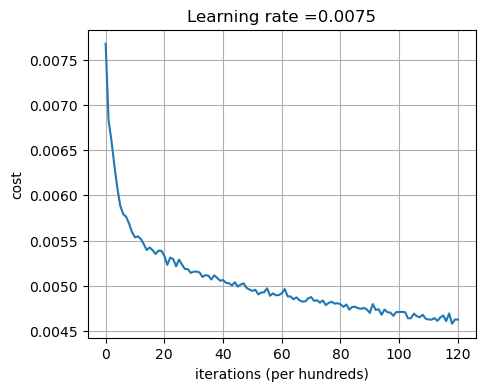

In [61]:
plot_costs(m4_costs,learning_rate=0.0075)

### Model # 05

In [62]:
m5_parameters, m5_costs, m5_train_accuracy, m5_test_accuracy = load_model('model_5')

Accuracy: 92.97
F1 score: 0.9414841342550179


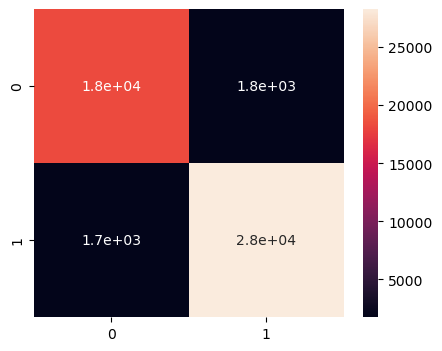

In [63]:
plot_confusion_Matrix(m5_parameters,model_tr_acc,'model-5',X_train_s,y_train)

Accuracy: 87.35
F1 score: 0.8946447905388524


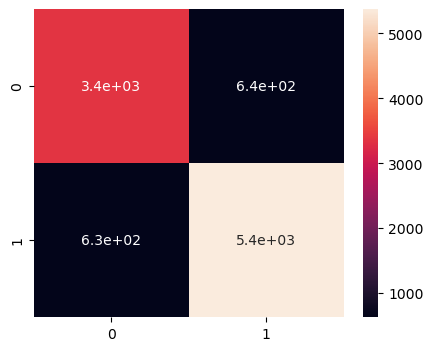

In [64]:
plot_confusion_Matrix(m5_parameters,model_ts_acc,'model-5',X_test_s,y_test)

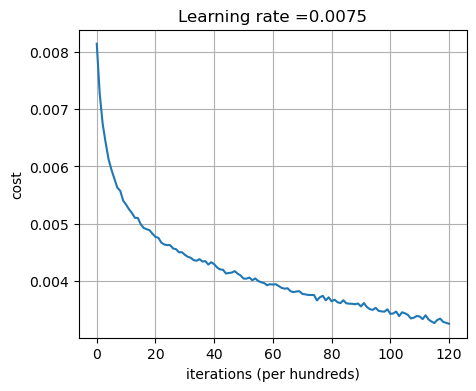

In [65]:
plot_costs(m5_costs,learning_rate=0.0075)

### Model # 06

In [66]:
m6_parameters, m6_costs, m6_train_accuracy, m6_test_accuracy = load_model('model_6')

Accuracy: 93.31
F1 score: 0.9430952380952381


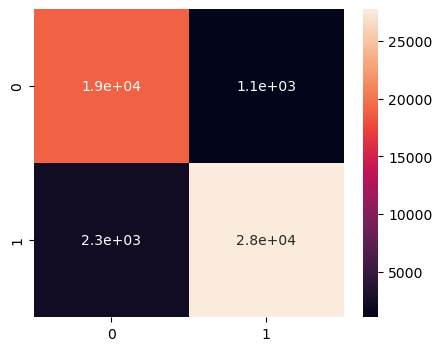

In [67]:
plot_confusion_Matrix(m6_parameters,model_tr_acc,'model-6',X_train_s,y_train)

Accuracy: 87.01
F1 score: 0.8892488703214255


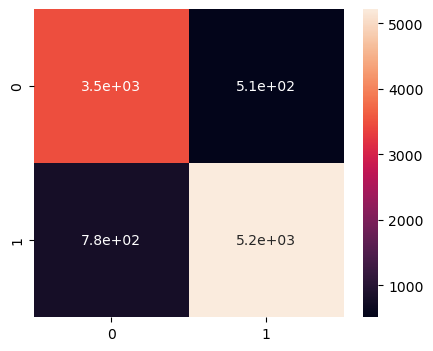

In [68]:
plot_confusion_Matrix(m6_parameters,model_ts_acc,'model-6',X_test_s,y_test)

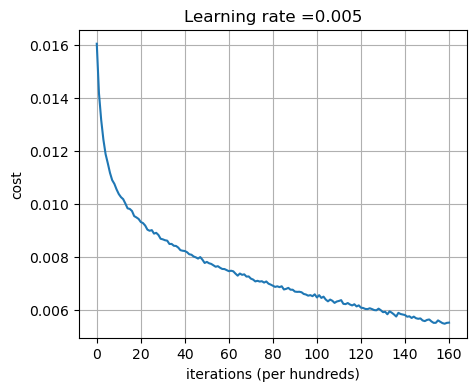

In [69]:
plot_costs(m6_costs,learning_rate=0.005)

## Problem of vanishing gradient

### Model # 07

In [70]:
m7_parameters, m7_costs, m7_train_accuracy, m7_test_accuracy = load_model('model_7')

Accuracy: 96.66
F1 score: 0.9723266482288062


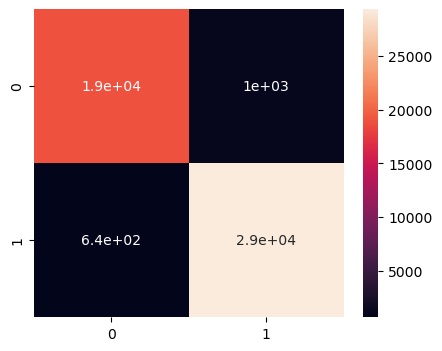

In [71]:
plot_confusion_Matrix(m7_parameters,model_tr_acc,'model-7',X_train_s,y_train)

Accuracy: 88.01
F1 score: 0.9011297105632061


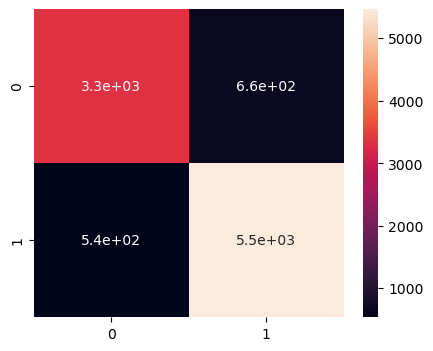

In [72]:
plot_confusion_Matrix(m7_parameters,model_ts_acc,'model-7',X_test_s,y_test)

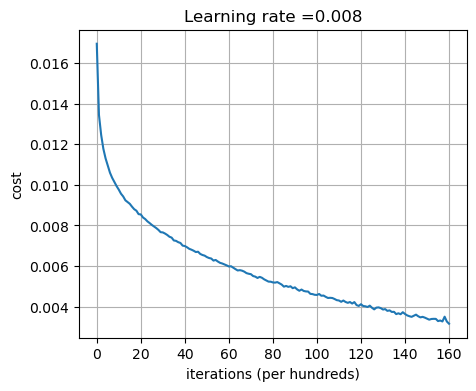

In [73]:
plot_costs(m7_costs,learning_rate=0.008)

### Model # 08

In [74]:
m8_parameters, m8_costs, m8_train_accuracy, m8_test_accuracy = load_model('model_8')

Accuracy: 95.04
F1 score: 0.9586365760833278


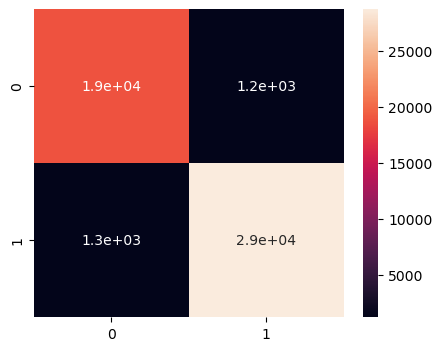

In [75]:
plot_confusion_Matrix(m8_parameters,model_tr_acc,'model-8',X_train_s,y_train)

Accuracy: 87.47
F1 score: 0.8951902969468841


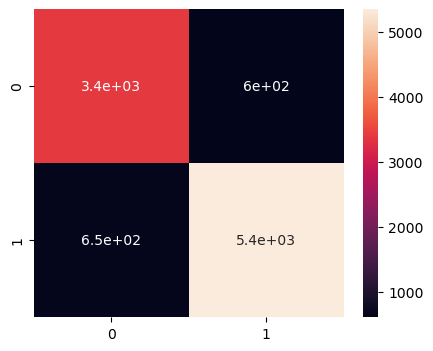

In [76]:
plot_confusion_Matrix(m8_parameters,model_ts_acc,'model-8',X_test_s,y_test)

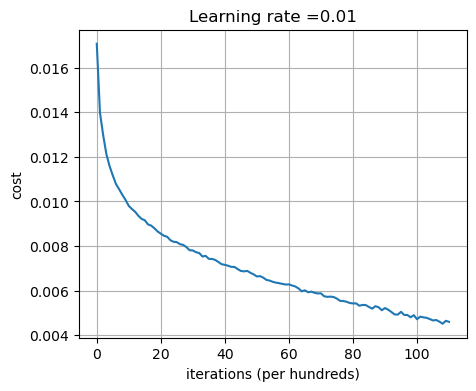

In [77]:
plot_costs(m8_costs,learning_rate=0.01)

# Regularization

In [78]:

def compute_cost_with_regularization(AL, Y, parameters, lambd):

    m = Y.shape[1]
    L = len(parameters) // 2

    cross_entropy_cost = compute_cost(AL, Y) # This gives you the cross-entropy part of the cost

    L2_regularization_cost = 0

    for l in range(1, L + 1):
        L2_regularization_cost += np.sum(parameters["W" + str(l)])

    L2_regularization_cost = lambd*(L2_regularization_cost)/(2*m)
    cost = cross_entropy_cost + L2_regularization_cost

    return cost


In [79]:

def schedule_lr_decay(learning_rate0, epoch_num, decay_rate, time_interval=5):

    learning_rate = learning_rate0/(1+(decay_rate*(epoch_num//time_interval)))

    return learning_rate

### Model Definition # 04

In [80]:
def build_model_with_optimizer_and_reg(X, Y, layers_dims, optimizer, learning_rate = 0.0007, mini_batch_size = 64, beta = 0.9,
          beta1 = 0.9, beta2 = 0.999,  epsilon = 1e-8, num_epochs = 5000, print_cost = True,lambd = 0,decay=None,decay_rate=1):

    L = len(layers_dims)
    costs = []
    train_acc = []
    test_acc = []
    t = 0
    seed = 10
    m = X.shape[1]
    learning_rate0 = learning_rate

    parameters = initialize_parameters(layers_dims)

    # Initialize the optimizer
    if optimizer == "gd":
        pass # no initialization required for gradient descent
    elif optimizer == "momentum":
        v = initialize_velocity(parameters)
    elif optimizer == "adam":
        v, s = initialize_adam(parameters)

    for i in range(num_epochs):

        seed = seed + 1
        minibatches = random_mini_batches(X, Y, mini_batch_size, seed)
        cost_total = 0

        for minibatch in minibatches:

            # Select a minibatch
            (minibatch_X, minibatch_Y) = minibatch

            # Forward propagation
            al, caches = forward_propagation(minibatch_X, parameters)

            # Compute cost and add to the cost total
            if lambd == 0:
                cost_total += compute_cost(al, minibatch_Y)
            else:
                cost_total += compute_cost_with_regularization(al, minibatch_Y,parameters,lambd)

            # Backward propagation
            grads = backward_propagation(al, minibatch_Y, caches,lambd)

            # Update parameters
            if optimizer == "gd":
                parameters = update_parameters(parameters, grads, learning_rate)
            elif optimizer == "momentum":
                parameters, v = update_parameters_with_momentum(parameters, grads, v, beta, learning_rate)
            elif optimizer == "adam":
                t = t + 1  # Adam counter
                parameters, v, s = update_parameters_with_adam(parameters, grads, v, s,
                                                               t, learning_rate, beta1, beta2,  epsilon)
        cost_avg = cost_total / m
        costs.append(cost_avg)

        if decay:
            learning_rate = decay(learning_rate0, i, decay_rate)

        print ("Cost after epoch %i: %f" %(i, cost_avg))
        print('Train',end=' ')
        _, tr_acc = predict(X, Y, parameters, 0.5)
        print('Test',end=' ')
        _, ts_acc = predict(X_test, y_test, parameters, 0.5)
        train_acc.append(tr_acc)
        test_acc.append(ts_acc)

    acc_cost = {'cost':costs,'train_accuracy':train_acc,'test_accuracy':test_acc}
    return parameters,acc_cost


### Model # 09

In [81]:
m9_parameters, m9_costs, m9_train_accuracy, m9_test_accuracy = load_model('model_9')

Accuracy: 92.32
F1 score: 0.9388431331942078


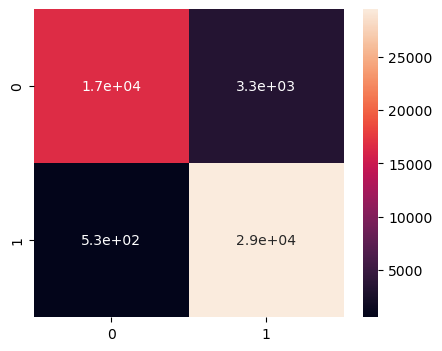

In [82]:
plot_confusion_Matrix(m9_parameters,model_tr_acc,'model-9',X_train_s,y_train)

Accuracy: 87.87
F1 score: 0.9040120281712432


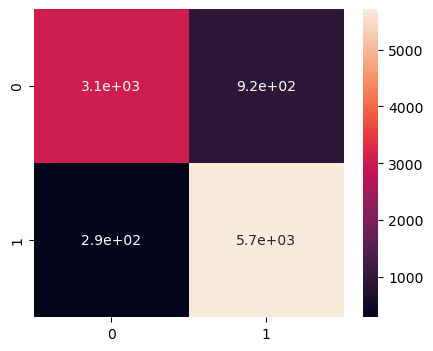

In [83]:
plot_confusion_Matrix(m9_parameters,model_ts_acc,'model-9',X_test_s,y_test)

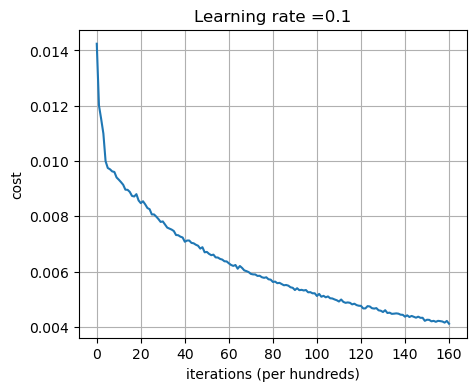

In [84]:
plot_costs(m9_costs,learning_rate=0.1)

### Model # 10

In [85]:
m10_parameters, m10_costs, m10_train_accuracy, m10_test_accuracy = load_model('model_10')

Accuracy: 94.26
F1 score: 0.9532615950640597


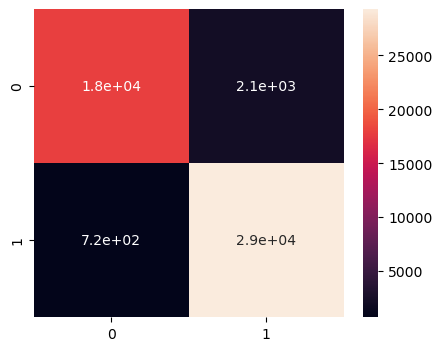

In [86]:
plot_confusion_Matrix(m10_parameters,model_tr_acc,'model-10',X_train_s,y_train)

Accuracy: 88.02
F1 score: 0.9030587473701246


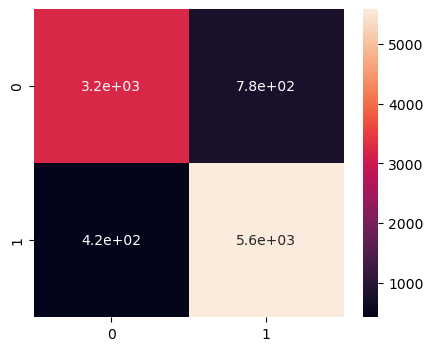

In [87]:
plot_confusion_Matrix(m10_parameters,model_ts_acc,'model-10',X_test_s,y_test)

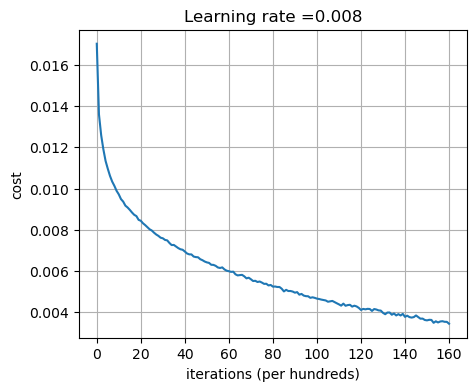

In [88]:
plot_costs(m10_costs,learning_rate=0.008)

## Model Definition # 05

In [89]:
def build_model_with_optimizer_reg_and_drop(X, Y, layers_dims, optimizer, learning_rate = 0.0007, mini_batch_size = 64, beta = 0.9,
          beta1 = 0.9, beta2 = 0.999,  epsilon = 1e-8, num_epochs = 5000, print_cost = True,lambd = 0,decay=None,decay_rate=1,
                                           keep_prob = 1,rgb=True):

    L = len(layers_dims)
    costs = []
    train_acc = []
    test_acc = []
    t = 0
    seed = 10
    m = X.shape[1]
    learning_rate0 = learning_rate

    parameters = initialize_parameters(layers_dims)

    # Initialize the optimizer
    if optimizer == "gd":
        pass # no initialization required for gradient descent
    elif optimizer == "momentum":
        v = initialize_velocity(parameters)
    elif optimizer == "adam":
        v, s = initialize_adam(parameters)

    for i in range(num_epochs):

        seed = seed + 1
        minibatches = random_mini_batches(X, Y, mini_batch_size, seed)
        cost_total = 0

        for minibatch in minibatches:

            # Select a minibatch
            (minibatch_X, minibatch_Y) = minibatch

            # Forward propagation
            al, caches = forward_propagation(minibatch_X, parameters,keep_prob)

            # Compute cost and add to the cost total
            if lambd == 0:
                cost_total += compute_cost(al, minibatch_Y)
            else:
                cost_total += compute_cost_with_regularization(al, minibatch_Y,parameters,lambd)

            # Backward propagation
            grads = backward_propagation(al, minibatch_Y, caches,lambd,)

            # Update parameters
            if optimizer == "gd":
                parameters = update_parameters(parameters, grads, learning_rate)
            elif optimizer == "momentum":
                parameters, v = update_parameters_with_momentum(parameters, grads, v, beta, learning_rate)
            elif optimizer == "adam":
                t = t + 1  # Adam counter
                parameters, v, s = update_parameters_with_adam(parameters, grads, v, s,
                                                               t, learning_rate, beta1, beta2,  epsilon)
        cost_avg = cost_total / m
        costs.append(cost_avg)

        if decay:
            learning_rate = decay(learning_rate0, i, decay_rate)


        print ("Cost after epoch %i: %f" %(i, cost_avg))
        print('Train',end=' ')
        if rgb:
            _, tr_acc = predict(X, Y, parameters, 0.5)
            print('Test',end=' ')
            _, ts_acc = predict(X_test_s, y_test, parameters, 0.5)
        else:
            _, tr_acc = predict(X, Y, parameters, 0.5)
            print('Test',end=' ')
            _, ts_acc = predict(X_test_g, y_test, parameters, 0.5)

        train_acc.append(tr_acc)
        test_acc.append(ts_acc)
    acc_cost = {'cost':costs,'train_accuracy':train_acc,'test_accuracy':test_acc}
    return parameters,acc_cost


### Model # 11

In [90]:
m11_parameters, m11_costs, m11_train_accuracy, m11_test_accuracy = load_model('model_11')

Accuracy: 90.26
F1 score: 0.9191816960063713


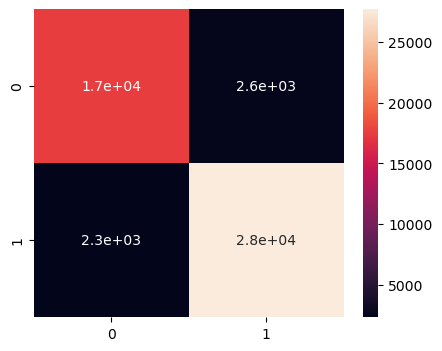

In [91]:
plot_confusion_Matrix(m11_parameters,model_tr_acc,'model-11',X_train_s,y_train)

Accuracy: 87.67
F1 score: 0.8975828557189136


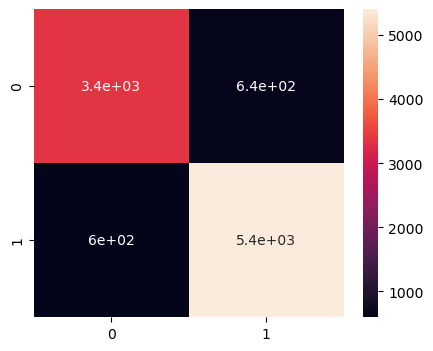

In [92]:
plot_confusion_Matrix(m11_parameters,model_ts_acc,'model-11',X_test_s,y_test)

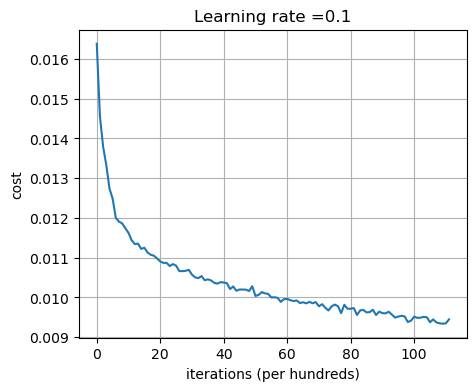

In [93]:
plot_costs(m11_costs,learning_rate=0.1)

### Model # 12

In [94]:
m12_parameters, m12_costs, m12_train_accuracy, m12_test_accuracy = load_model('model_12')

Accuracy: 93.71
F1 score: 0.9477567298105684


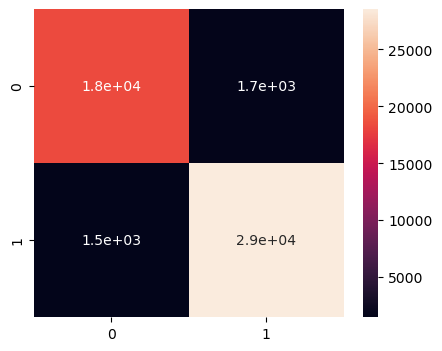

In [95]:
plot_confusion_Matrix(m12_parameters,model_tr_acc,'model-12',X_train_s,y_train)

Accuracy: 88.44
F1 score: 0.904098224655716


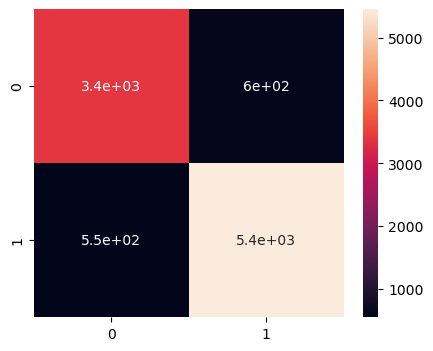

In [96]:
plot_confusion_Matrix(m12_parameters,model_ts_acc,'model-12',X_test_s,y_test)

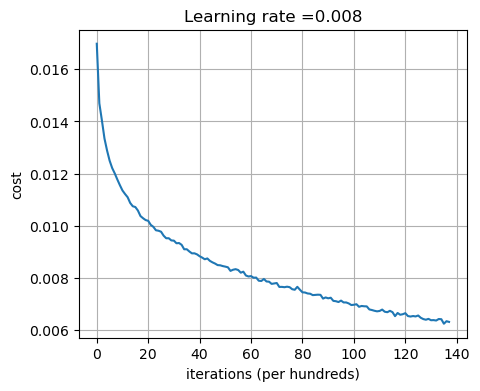

In [97]:
plot_costs(m12_costs,learning_rate=0.008)

### Model # 13

In [98]:
m13_parameters, m13_costs, m13_train_accuracy, m13_test_accuracy = load_model('model_13')

Accuracy: 90.06
F1 score: 0.9178349424679276


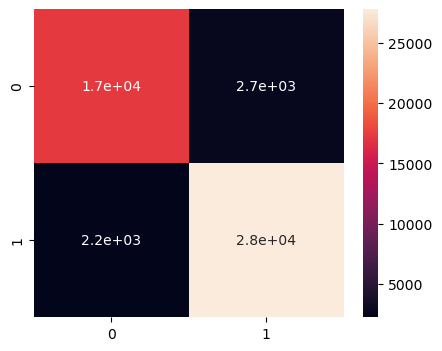

In [99]:
plot_confusion_Matrix(m13_parameters,model_tr_acc,'model-13',X_train_s,y_train)

Accuracy: 88.03
F1 score: 0.9013271783035198


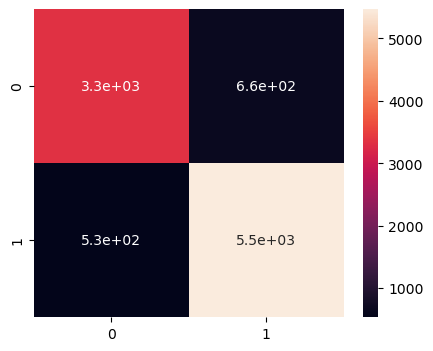

In [100]:
plot_confusion_Matrix(m13_parameters,model_ts_acc,'model-13',X_test_s,y_test)

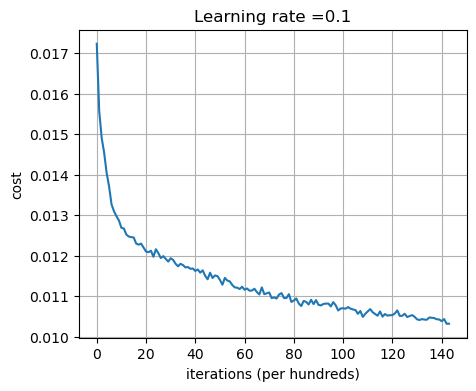

In [101]:
plot_costs(m13_costs,learning_rate=0.1)

### Model # 14

In [102]:
m14_parameters, m14_costs, m14_train_accuracy, m14_test_accuracy = load_model('model_14')

Accuracy: 90.09
F1 score: 0.9170364169108414


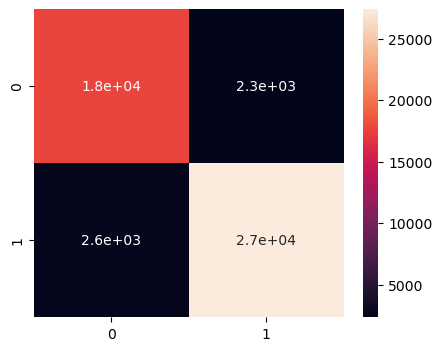

In [103]:
plot_confusion_Matrix(m14_parameters,model_tr_acc,'model-14',X_train_s,y_train)

Accuracy: 88.13
F1 score: 0.900727607259346


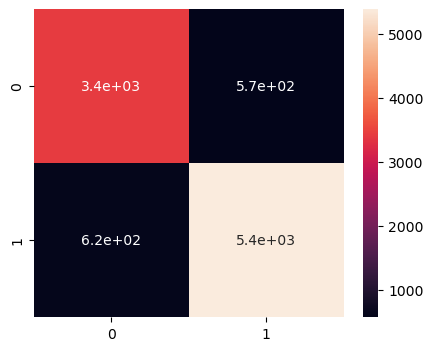

In [104]:
plot_confusion_Matrix(m14_parameters,model_ts_acc,'model-14',X_test_s,y_test)

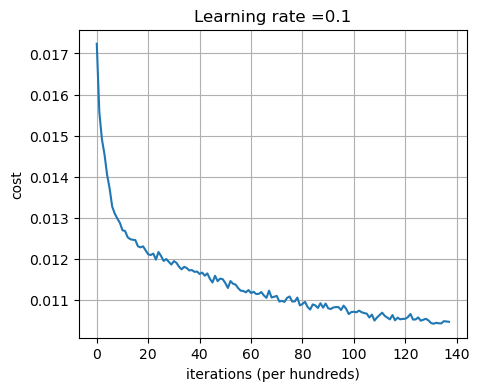

In [105]:
plot_costs(m14_costs,learning_rate=0.1)

### Model # 15

In [106]:
m15_parameters, m15_costs, m15_train_accuracy, m15_test_accuracy = load_model('model_15')

Accuracy: 88.4
F1 score: 0.9094966835739368


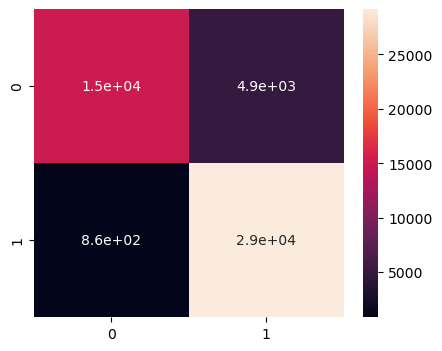

In [107]:
plot_confusion_Matrix(m15_parameters,model_tr_acc,'model-15',X_train_s,y_train)

Accuracy: 86.4
F1 score: 0.8940314788842139


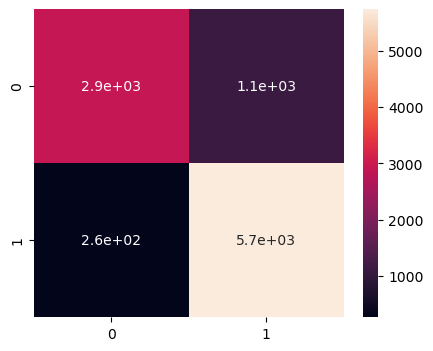

In [108]:
plot_confusion_Matrix(m15_parameters,model_ts_acc,'model-15',X_test_s,y_test)

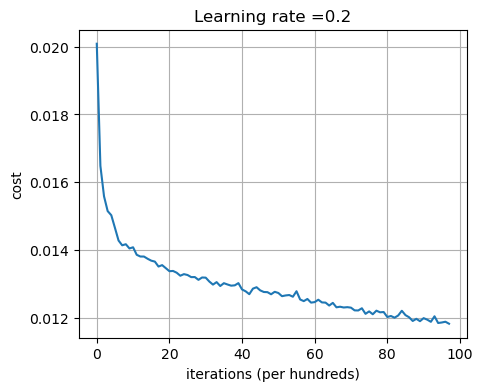

In [109]:
plot_costs(m15_costs,learning_rate=0.2)

### Model # 16

In [110]:
m16_parameters, m16_costs, m16_train_accuracy, m16_test_accuracy = load_model('model_16')

Accuracy: 96.38
F1 score: 0.9701053744260563


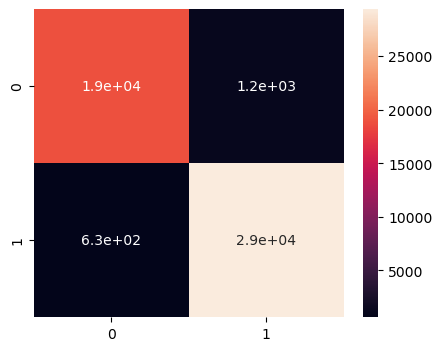

In [111]:
plot_confusion_Matrix(m16_parameters,model_tr_acc,'model-16',X_train_s,y_train)

Accuracy: 88.88
F1 score: 0.9087776866283839


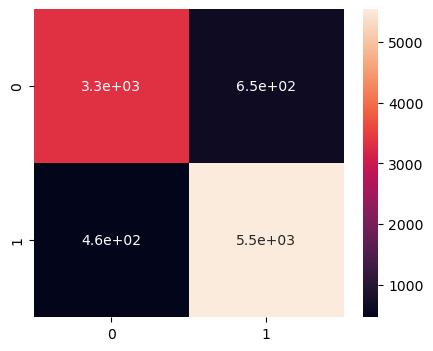

In [112]:
plot_confusion_Matrix(m16_parameters,model_ts_acc,'model-16',X_test_s,y_test)

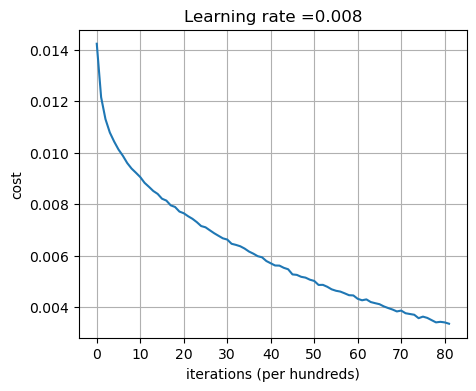

In [113]:
plot_costs(m16_costs,learning_rate=0.008)

### Model # 17

In [114]:
m17_parameters, m17_costs, m17_train_accuracy, m17_test_accuracy = load_model('model_17')

Accuracy: 89.59
F1 score: 0.9144162653473809


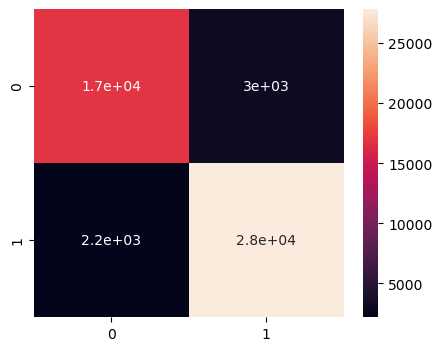

In [115]:
plot_confusion_Matrix(m17_parameters,model_tr_acc,'model-17',X_train_s,y_train)

Accuracy: 88.02
F1 score: 0.901754961456454


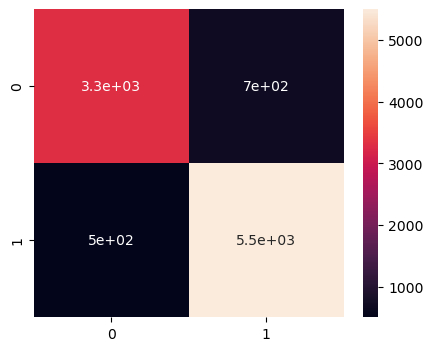

In [116]:
plot_confusion_Matrix(m17_parameters,model_ts_acc,'model-17',X_test_s,y_test)

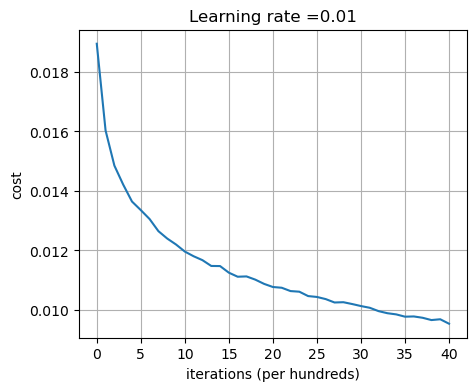

In [117]:
plot_costs(m17_costs,learning_rate=0.01)

# Comparing 17 Models

## Train Accuracy

(40.0, 100.0)

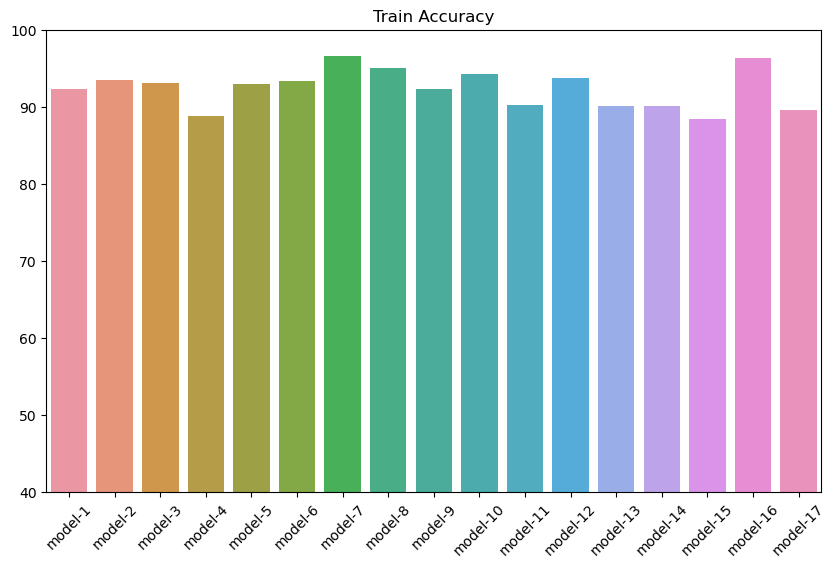

In [118]:
fig, ax = plt.subplots(figsize=(10,6))
plot = sns.barplot(x=[i.name for i in model_tr_acc],y=[i.acc for i in model_tr_acc])
plt.xticks(rotation=45)
plt.title("Train Accuracy")
plot.set_ylim((40,100))

## Train F1-score

(0.4, 1.0)

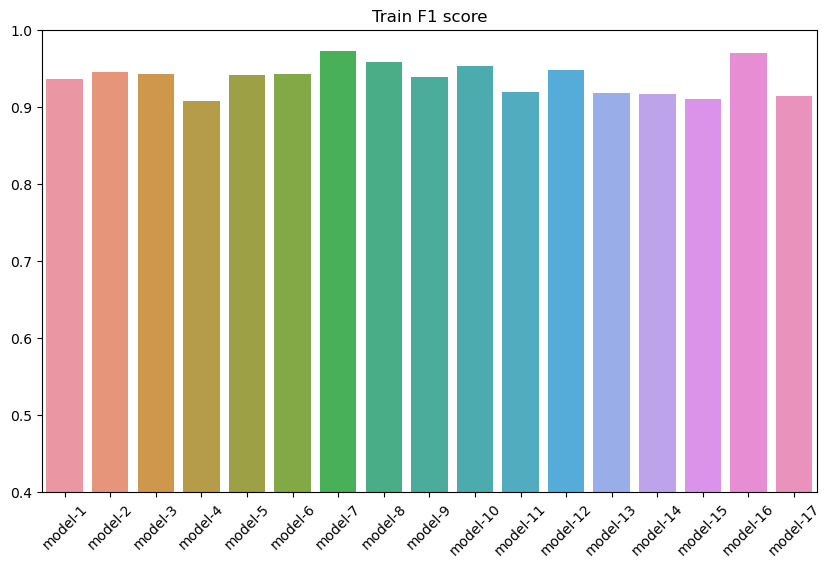

In [119]:
fig, ax = plt.subplots(figsize=(10,6))
plot = sns.barplot(x=[i.name for i in model_tr_acc],y=[i.f1 for i in model_tr_acc])
plt.xticks(rotation=45)
plt.title("Train F1 score")
plot.set_ylim((0.4,1))

## Test Accuracy

(40.0, 91.0)

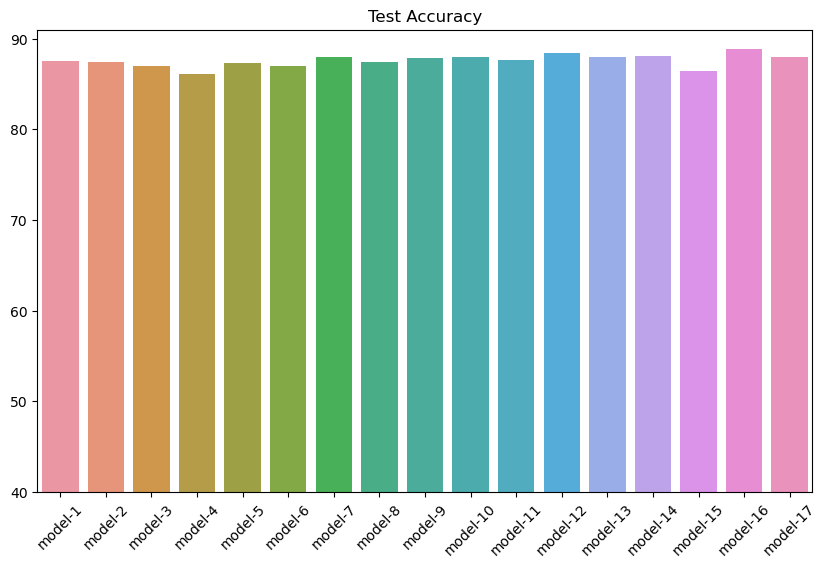

In [120]:
fig, ax = plt.subplots(figsize=(10,6))
plot = sns.barplot(x=[i.name for i in model_ts_acc],y=[i.acc for i in model_ts_acc])
plt.xticks(rotation=45)
plt.title("Test Accuracy")
plot.set_ylim((40,91))

## Test F1 Score

(0.4, 0.93)

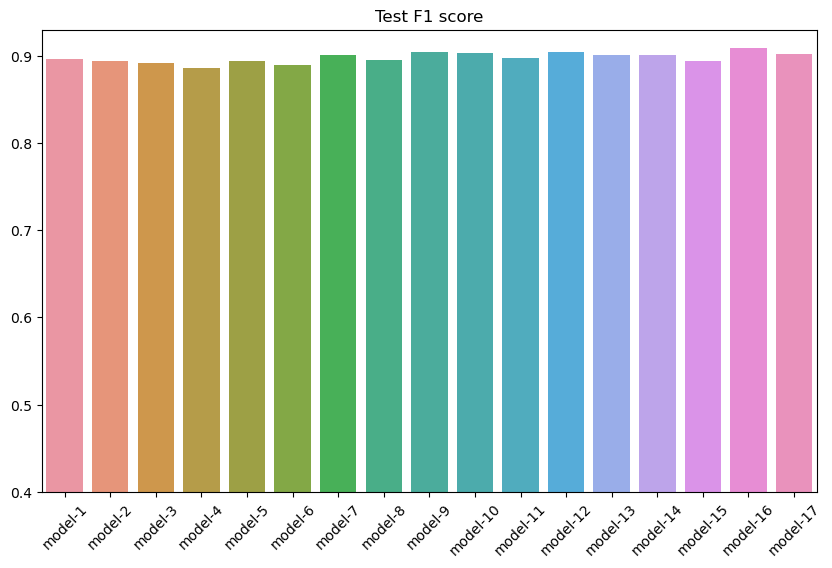

In [121]:
fig, ax = plt.subplots(figsize=(10,6))
plot = sns.barplot(x=[i.name for i in model_ts_acc],y=[i.f1 for i in model_ts_acc])
plt.xticks(rotation=45)
plt.title("Test F1 score")
plot.set_ylim((0.4,0.93))

In [122]:
drawTable(model_tr_acc,model_ts_acc)

,Training Accuracy,Train F1 Score,Test Accuracy,Test F1 Score
Model Name,,,,
model-1,92.35,93.63,87.60,89.63
model-2,93.54,94.53,87.49,89.43
model-3,93.06,94.22,87.05,89.15
model-4,88.77,90.72,86.10,88.59
model-5,92.97,94.15,87.35,89.46
model-6,93.31,94.31,87.01,88.92
model-7,96.66,97.23,88.01,90.11
model-8,95.04,95.86,87.47,89.52
model-9,92.32,93.88,87.87,90.40


**Conclusion:**
- We use f1 score and accuracy as a metrics.
- Each and every model perform well.
- Among 17 models `model-7`, `model-10` & `model-16` are best models. 

# Logistic Regression

In [123]:
model_tr_acc_log = []
model_ts_acc_log = []

### Shallow Model # 01

In [124]:
logit_parameters_1, logit_costs_1, logit_train_accuracy_1, logit_test_accuracy_1 = load_model('log_reg_1')

Accuracy: 73.49
F1 score: 0.8024676640638969


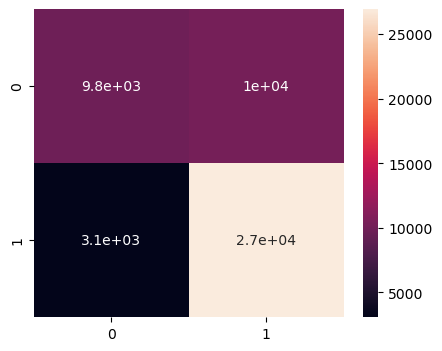

In [125]:
plot_confusion_Matrix(logit_parameters_1,model_tr_acc_log,'log_reg_1',X_train_g,y_train)

Accuracy: 72.46
F1 score: 0.7937387657279809


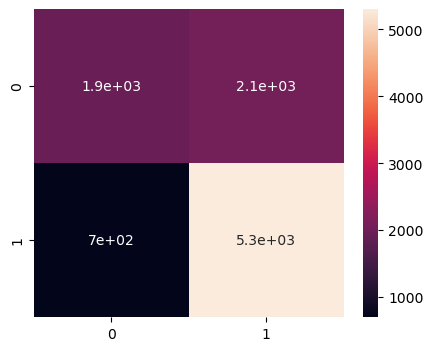

In [126]:
plot_confusion_Matrix(logit_parameters_1,model_ts_acc_log,'log_reg_1',X_test_g,y_test)

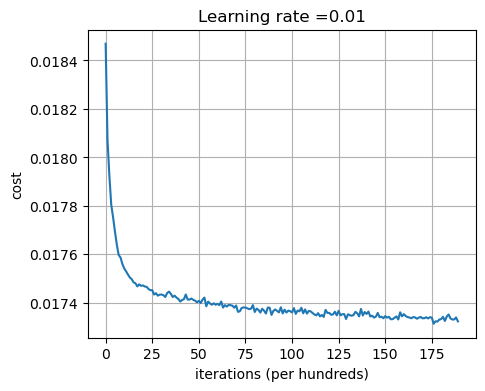

In [127]:
plot_costs(logit_costs_1,learning_rate=0.01)

### Shallow Model # 02

In [128]:
logit_parameters_2, logit_costs_2, logit_train_accuracy_2, logit_test_accuracy_2 = load_model('log_reg_2')

Accuracy: 73.2
F1 score: 0.8048695246971109


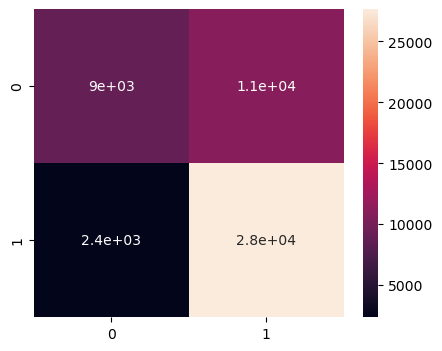

In [129]:
plot_confusion_Matrix(logit_parameters_2,model_tr_acc_log,'log_reg_2',X_train_g,y_train)

Accuracy: 72.14
F1 score: 0.7960169863816078


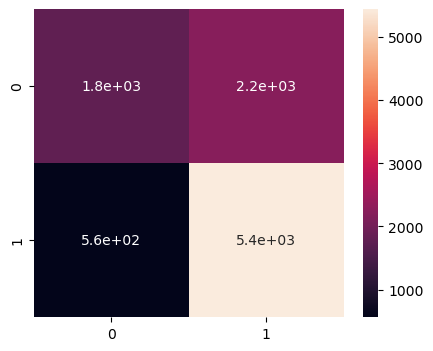

In [130]:
plot_confusion_Matrix(logit_parameters_2,model_ts_acc_log,'log_reg_2',X_test_g,y_test)

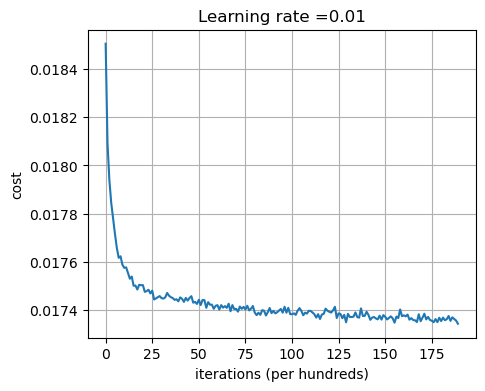

In [131]:
plot_costs(logit_costs_2,learning_rate=0.01)

### Shallow Model # 03

In [132]:
logit_parameters_3, logit_costs_3, logit_train_accuracy_3, logit_test_accuracy_3 = load_model('log_reg_3')

Accuracy: 79.09
F1 score: 0.8075252190560341


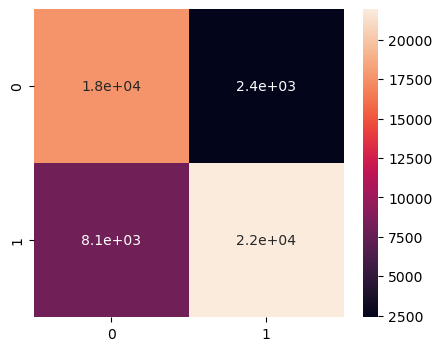

In [133]:
plot_confusion_Matrix(logit_parameters_3,model_tr_acc_log,'log_reg_3',X_train_s,y_train)

Accuracy: 78.16
F1 score: 0.7987096774193547


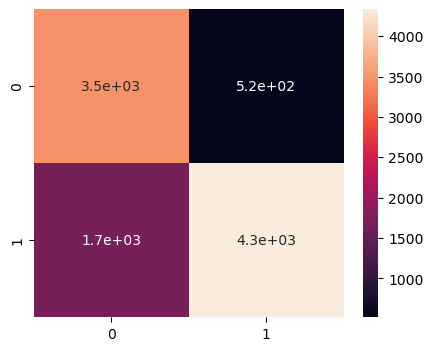

In [134]:
plot_confusion_Matrix(logit_parameters_3,model_ts_acc_log,'log_reg_3',X_test_s,y_test)

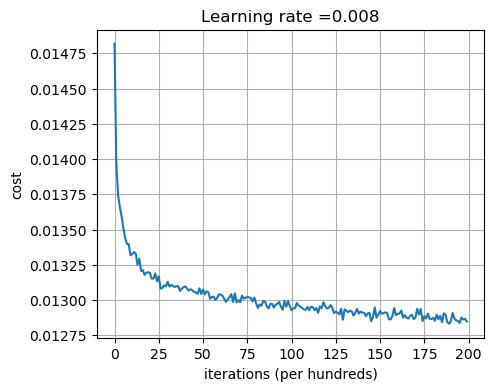

In [135]:
plot_costs(logit_costs_3,learning_rate=0.008)

### Shallow Model # 04

In [136]:
logit_parameters_4, logit_costs_4, logit_train_accuracy_4, logit_test_accuracy_4 = load_model('log_reg_4')

Accuracy: 82.16
F1 score: 0.846421317175612


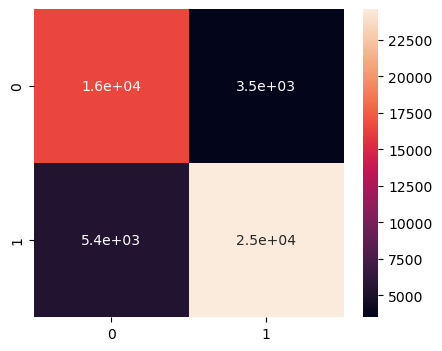

In [137]:
plot_confusion_Matrix(logit_parameters_4,model_tr_acc_log,'log_reg_4',X_train_s,y_train)

Accuracy: 81.06
F1 score: 0.8368928694454013


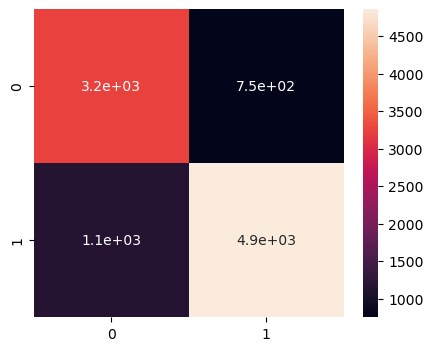

In [138]:
plot_confusion_Matrix(logit_parameters_4,model_ts_acc_log,'log_reg_4',X_test_s,y_test)

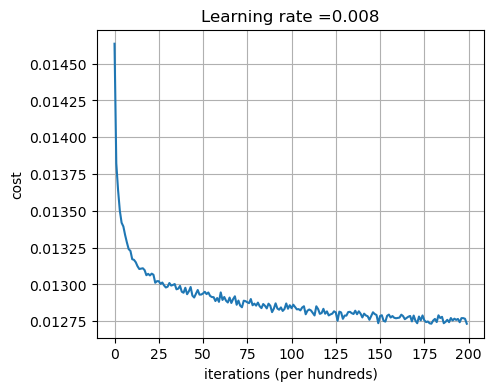

In [139]:
plot_costs(logit_costs_4,learning_rate=0.008)

# Comparing 4 Shallow Models

### Train Accuracy

(40.0, 90.0)

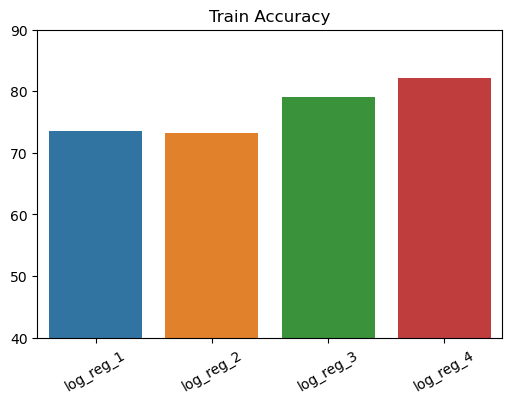

In [140]:
fig, ax = plt.subplots(figsize=(6,4))
plot = sns.barplot(x=[i.name for i in model_tr_acc_log],y=[i.acc for i in model_tr_acc_log])
plt.xticks(rotation=30)
plt.title("Train Accuracy")
plot.set_ylim((40,90))

### Train F1 Score

(0.4, 0.9)

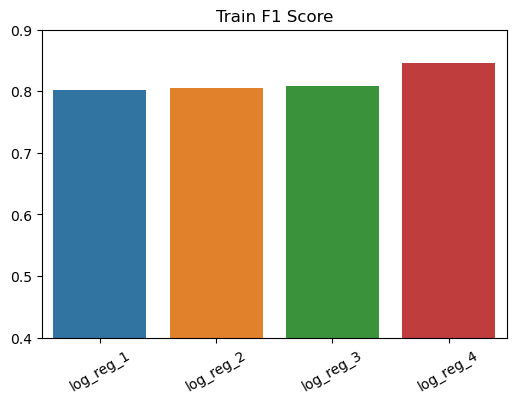

In [141]:
fig, ax = plt.subplots(figsize=(6,4))
plot = sns.barplot(x=[i.name for i in model_tr_acc_log],y=[i.f1 for i in model_tr_acc_log])
plt.xticks(rotation=30)
plt.title("Train F1 Score")
plot.set_ylim((.40,.90))

### Test Accuracy

(40.0, 90.0)

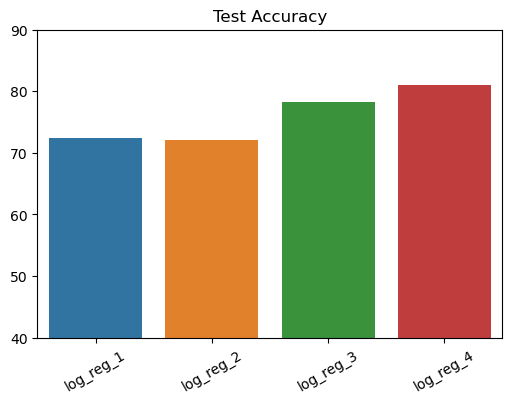

In [142]:
fig, ax = plt.subplots(figsize=(6,4))
plot = sns.barplot(x=[i.name for i in model_ts_acc_log],y=[i.acc for i in model_ts_acc_log])
plt.xticks(rotation=30)
plt.title("Test Accuracy")
plot.set_ylim((40,90))

### Test F1 Score

(0.4, 0.9)

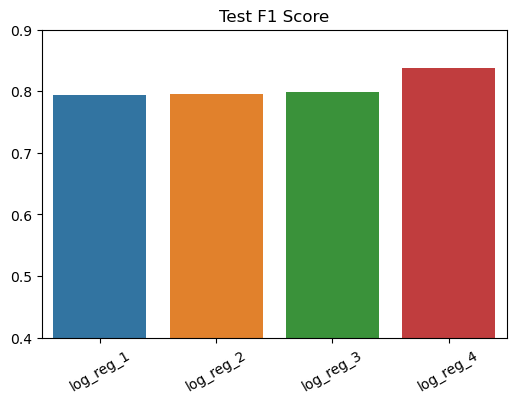

In [143]:
fig, ax = plt.subplots(figsize=(6,4))
plot = sns.barplot(x=[i.name for i in model_ts_acc_log],y=[i.f1 for i in model_ts_acc_log])
plt.xticks(rotation=30)
plt.title("Test F1 Score")
plot.set_ylim((.40,.90))

In [144]:
drawTable(model_tr_acc_log, model_ts_acc_log)

,Training Accuracy,Train F1 Score,Test Accuracy,Test F1 Score
Model Name,,,,
log_reg_1,73.49,80.25,72.46,79.37
log_reg_2,73.20,80.49,72.14,79.60
log_reg_3,79.09,80.75,78.16,79.87
log_reg_4,82.16,84.64,81.06,83.69


**Conclusion:**
- However they are shallow algorithms but perform more than expectations.
- Among 4 models `log_reg_4` perform well. 

# Now Trying out Tensorflow

In [145]:
model_tr_acc_tf = []
model_ts_acc_tf = []

In [146]:
test, valid = random_mini_batches(X_test_s,y_test, mini_batch_size = 5000, seed = 0)
X_test_tf, y_test_tf = test
X_valid_tf, y_valid_tf = valid

In [147]:
np.random.seed(42)
tf.random.set_seed(42)

### Model # 01

In [148]:
model = keras.models.Sequential()
model.add(keras.layers.Flatten(input_shape=[32*32*3]))
model.add(keras.layers.Dense(300,activation='relu'))
model.add(keras.layers.Dense(100,activation='relu'))
model.add(keras.layers.Dense(1,activation='sigmoid'))

In [149]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 3072)              0         
                                                                 
 dense (Dense)               (None, 300)               921900    
                                                                 
 dense_1 (Dense)             (None, 100)               30100     
                                                                 
 dense_2 (Dense)             (None, 1)                 101       
                                                                 
Total params: 952,101
Trainable params: 952,101
Non-trainable params: 0
_________________________________________________________________


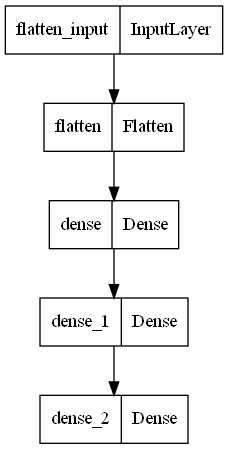

In [150]:
keras.utils.plot_model(model)

In [151]:
model = tf.keras.models.load_model('model.h5',compile=False)

In [152]:
model.compile(
    loss=tf.keras.losses.binary_crossentropy ,
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.008),
    metrics=['accuracy'])

1563/1563 [==============================] - 7s 4ms/step - loss: 0.3255 - accuracy: 0.8680


<Axes: >

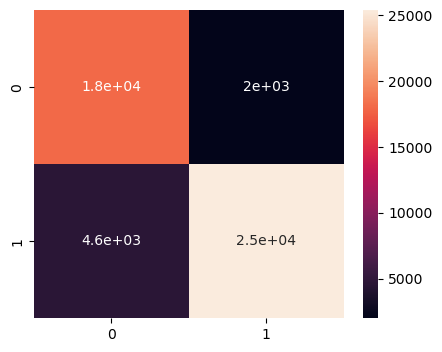

In [153]:
y_pred = model.predict(X_train_s.T) > 0.5
m1_train = Model('tf-1',model.evaluate(X_train_s.T,y_train.T,)[1],f1_score(y_train.ravel(),y_pred.T.ravel()))
sns.heatmap(confusion_matrix(y_train.ravel(),y_pred.T.ravel()),annot=True)

313/313 [==============================] - 1s 4ms/step - loss: 0.3998 - accuracy: 0.8396


<Axes: >

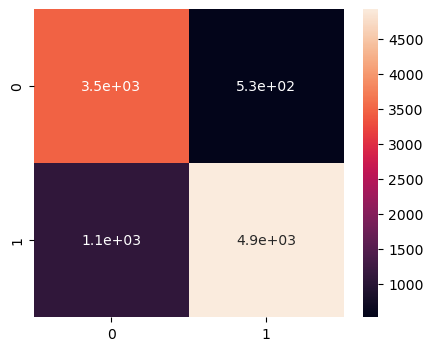

In [154]:
y_pred = model.predict(X_test_s.T) > 0.5
m1_test = Model('tf-1',model.evaluate(X_test_s.T,y_test.T,)[1],f1_score(y_test.ravel(),y_pred.T.ravel()))
sns.heatmap(confusion_matrix(y_test.ravel(),y_pred.T.ravel()),annot=True)

In [155]:
model_tr_acc_tf.append(m1_train)

In [156]:
model_ts_acc_tf.append(m1_test)

### Model # 02

In [157]:
input_ = keras.layers.Input(shape=3072)
hidden_1 = keras.layers.Dense(100, activation='relu')(input_)
hidden_2 = keras.layers.Dense(30, activation='relu')(hidden_1)
concat = keras.layers.concatenate([input_,hidden_2])
output = keras.layers.Dense(1,activation='sigmoid')(concat)
model2 = keras.models.Model(inputs=[input_],outputs=[output])

In [158]:
model2.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 3072)]       0           []                               
                                                                                                  
 dense_3 (Dense)                (None, 100)          307300      ['input_1[0][0]']                
                                                                                                  
 dense_4 (Dense)                (None, 30)           3030        ['dense_3[0][0]']                
                                                                                                  
 concatenate (Concatenate)      (None, 3102)         0           ['input_1[0][0]',                
                                                                  'dense_4[0][0]']            

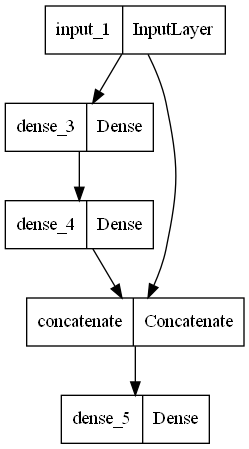

In [159]:
keras.utils.plot_model(model2)

In [160]:
model2 = tf.keras.models.load_model('model2.h5',compile=False)

In [161]:
model2.compile(
    loss=tf.keras.losses.binary_crossentropy ,
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.008),
    metrics=['accuracy'])

1563/1563 [==============================] - 5s 3ms/step - loss: 0.4839 - accuracy: 0.8076


<Axes: >

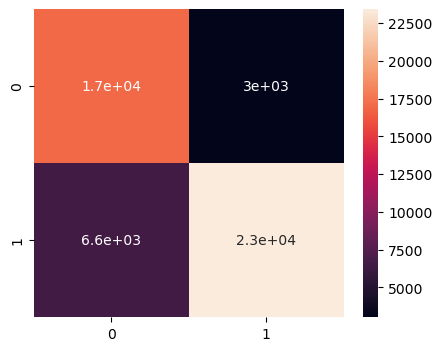

In [162]:
y_pred = model2.predict(X_train_s.T) > 0.5
m2_train = Model('tf-2',model2.evaluate(X_train_s.T,y_train.T,)[1],f1_score(y_train.ravel(),y_pred.T.ravel()))
sns.heatmap(confusion_matrix(y_train.ravel(),y_pred.T.ravel()),annot=True)

313/313 [==============================] - 1s 3ms/step - loss: 0.5166 - accuracy: 0.7948


<Axes: >

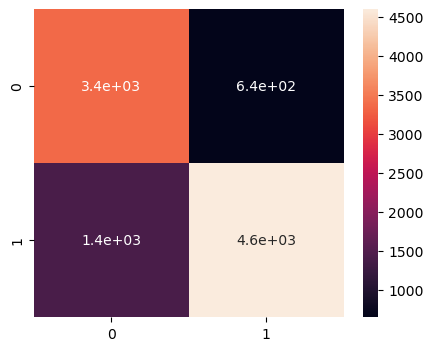

In [163]:
y_pred = model2.predict(X_test_s.T) > 0.5
m2_test = Model('tf-2',model2.evaluate(X_test_s.T,y_test.T,)[1],f1_score(y_test.ravel(),y_pred.T.ravel()))
sns.heatmap(confusion_matrix(y_test.ravel(),y_pred.T.ravel()),annot=True)

In [164]:
model_tr_acc_tf.append(m2_train)

In [165]:
model_ts_acc_tf.append(m1_test)

## Comparing Both Models

Text(0.5, 1.0, 'Test F1')

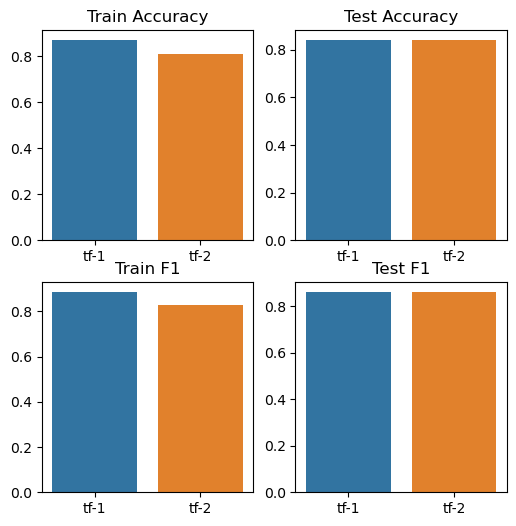

In [166]:
fig, ax = plt.subplots(2,2,figsize=(6,6))
sns.barplot(x=[i.name for i in model_tr_acc_tf],y=[i.acc for i in model_tr_acc_tf],ax=ax[0,0])
ax[0,0].set_title("Train Accuracy")
plot = sns.barplot(x=[i.name for i in model_tr_acc_tf],y=[i.f1 for i in model_tr_acc_tf],ax=ax[1,0])
ax[1,0].set_title("Train F1")
plot = sns.barplot(x=[i.name for i in model_tr_acc_tf],y=[i.acc for i in model_ts_acc_tf],ax=ax[0,1])
ax[0,1].set_title("Test Accuracy")
plot = sns.barplot(x=[i.name for i in model_tr_acc_tf],y=[i.f1 for i in model_ts_acc_tf],ax=ax[1,1])
ax[1,1].set_title("Test F1")

In [167]:
drawTable(model_tr_acc_tf, model_ts_acc_tf)

,Training Accuracy,Train F1 Score,Test Accuracy,Test F1 Score
Model Name,,,,
tf-1,0.86802,88.50,0.8396,85.99
tf-2,0.80764,82.96,0.8396,85.99


**Conclusion:**
- `tf-1` and `tf-2` both perform well. 

# KNN

- It takes hour to train.
- Run at your own risk.

In [168]:
model_tr_acc_knn = []
model_ts_acc_knn = []

##### Now reducing some pixels from gray scale image

##### Achieved same Accuracy but again it takes some time
###### Now reduce more pixels

In [169]:
pca = PCA(n_components = 250)
X_train_kn = pca.fit_transform(X_train_g.T)
X_test_kn = pca.transform(X_test_g.T)

In [170]:
pca = PCA(n_components = 200)
X_train_knn = pca.fit_transform(X_train_g.T)
X_test_knn = pca.transform(X_test_g.T)

### Model # 01

In [171]:
model_knn_1 = KNeighborsClassifier()
model_knn_1.fit(X_train_knn,y_train.T.ravel())

KNeighborsClassifier()

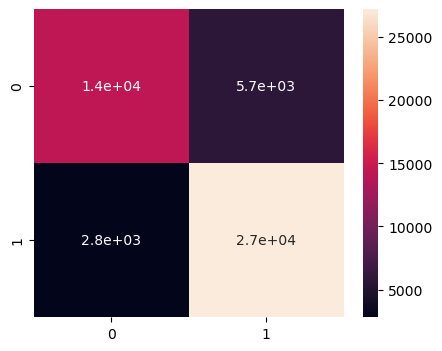

In [172]:
pr = model_knn_1.predict(X_train_knn)
acc = accuracy_score(y_train.T.ravel(),pr)
f1 = f1_score(y_train.T.ravel(),pr)
sns.heatmap(confusion_matrix(y_train.T.ravel(),pr),annot=True)
model_tr_acc_knn.append(Model("model_knn_1",acc,f1))

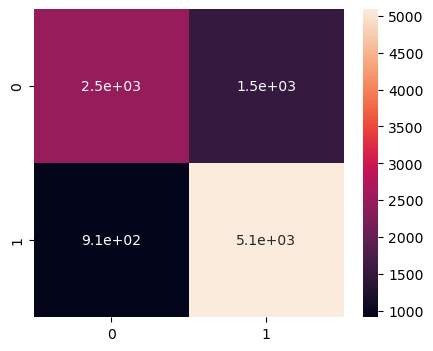

In [173]:
pr = model_knn_1.predict(X_test_knn)
acc = accuracy_score(y_test.T.ravel(),pr)
f1 = f1_score(y_test.T.ravel(),pr)
sns.heatmap(confusion_matrix(y_test.T.ravel(),pr),annot=True)
model_ts_acc_knn.append(Model("model_knn_1",acc,f1))

### Model # 02

In [174]:
model_knn_2 = KNeighborsClassifier(n_neighbors=7,weights='uniform',p=2)
model_knn_2.fit(X_train_knn,y_train.T.ravel())

KNeighborsClassifier(n_neighbors=7)

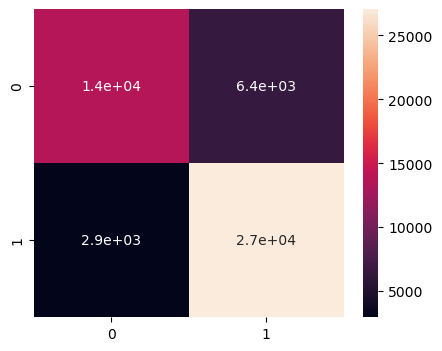

In [175]:
pr = model_knn_2.predict(X_train_knn)
acc = accuracy_score(y_train.T.ravel(),pr)
f1 = f1_score(y_train.T.ravel(),pr)
sns.heatmap(confusion_matrix(y_train.T.ravel(),pr),annot=True)
model_tr_acc_knn.append(Model("model_knn_2",acc,f1))

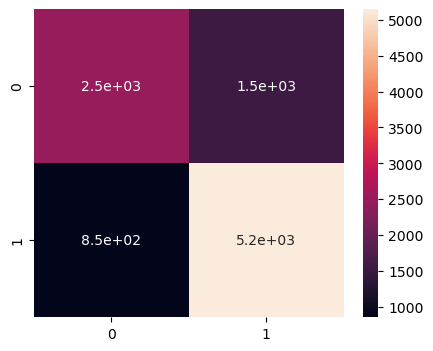

In [176]:
pr = model_knn_2.predict(X_test_knn)
acc = accuracy_score(y_test.T.ravel(),pr)
f1 = f1_score(y_test.T.ravel(),pr)
sns.heatmap(confusion_matrix(y_test.T.ravel(),pr),annot=True)
model_ts_acc_knn.append(Model("model_knn_2",acc,f1))

### Model # 03

In [177]:
model_knn_3 = KNeighborsClassifier(n_neighbors=11,weights='distance',p=1)
model_knn_3.fit(X_train_knn,y_train.T.ravel())

KNeighborsClassifier(n_neighbors=11, weights='distance')

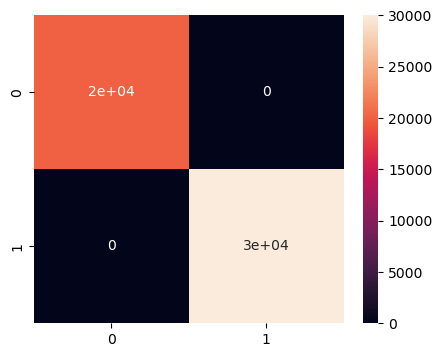

In [178]:
pr = model_knn_3.predict(X_train_knn)
acc = accuracy_score(y_train.T.ravel(),pr)
f1 = f1_score(y_train.T.ravel(),pr)
sns.heatmap(confusion_matrix(y_train.T.ravel(),pr),annot=True)
model_tr_acc_knn.append(Model("model_knn_3",acc,f1))

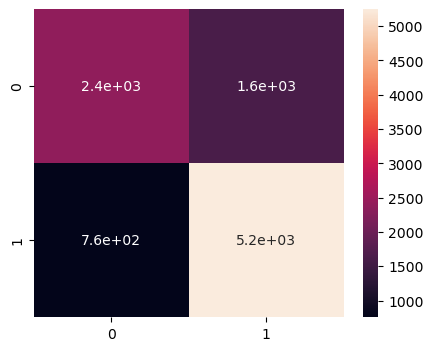

In [179]:
pr = model_knn_3.predict(X_test_knn)
acc = accuracy_score(y_test.T.ravel(),pr)
f1 = f1_score(y_test.T.ravel(),pr)
sns.heatmap(confusion_matrix(y_test.T.ravel(),pr),annot=True)
model_ts_acc_knn.append(Model("model_knn_3",acc,f1))

### Model # 04

In [180]:
model_knn_4 = KNeighborsClassifier(n_neighbors=11,weights='uniform',p=2)
model_knn_4.fit(X_train_knn,y_train.ravel())

KNeighborsClassifier(n_neighbors=11)

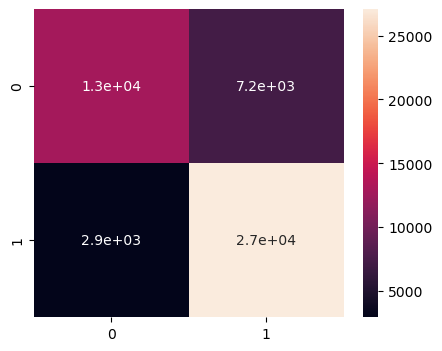

In [181]:
pr = model_knn_4.predict(X_train_knn)
acc = accuracy_score(y_train.T.ravel(),pr)
f1 = f1_score(y_train.T.ravel(),pr)
sns.heatmap(confusion_matrix(y_train.T.ravel(),pr),annot=True)
model_tr_acc_knn.append(Model("model_knn_4",acc,f1))

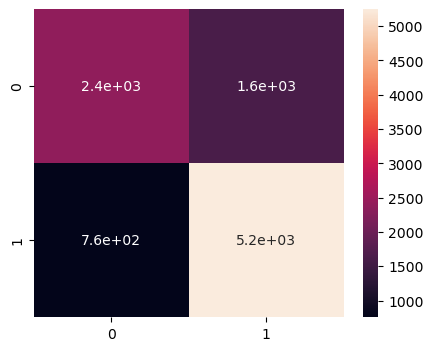

In [182]:
pr = model_knn_4.predict(X_test_knn)
acc = accuracy_score(y_test.T.ravel(),pr)
f1 = f1_score(y_test.T.ravel(),pr)
sns.heatmap(confusion_matrix(y_test.T.ravel(),pr),annot=True)
model_ts_acc_knn.append(Model("model_knn_4",acc,f1))

## Comparing 4 Models

Text(0.5, 1.0, 'Test F1')

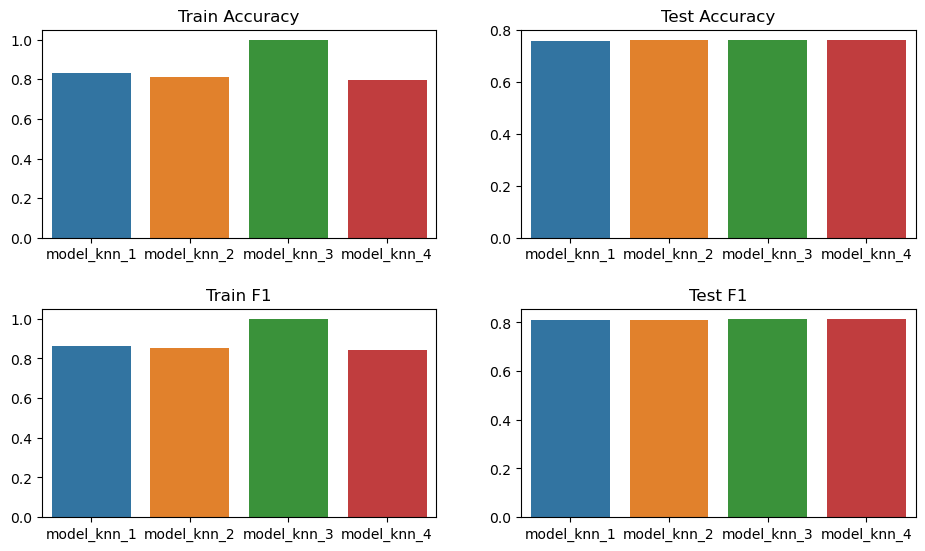

In [183]:
fig, ax = plt.subplots(2,2,figsize=(10,6))
fig.tight_layout(pad=3.0)
sns.barplot(x=[i.name for i in model_tr_acc_knn],y=[i.acc for i in model_tr_acc_knn],ax=ax[0,0])
ax[0,0].set_title("Train Accuracy")
plot = sns.barplot(x=[i.name for i in model_tr_acc_knn],y=[i.f1 for i in model_tr_acc_knn],ax=ax[1,0])
ax[1,0].set_title("Train F1")
plot = sns.barplot(x=[i.name for i in model_tr_acc_knn],y=[i.acc for i in model_ts_acc_knn],ax=ax[0,1])
ax[0,1].set_title("Test Accuracy")
plot = sns.barplot(x=[i.name for i in model_tr_acc_knn],y=[i.f1 for i in model_ts_acc_knn],ax=ax[1,1])
ax[1,1].set_title("Test F1")

In [184]:
drawTable(model_tr_acc_knn, model_ts_acc_knn)

,Training Accuracy,Train F1 Score,Test Accuracy,Test F1 Score
Model Name,,,,
model_knn_1,0.83018,86.50,0.7584,80.83
model_knn_2,0.81310,85.27,0.7619,81.22
model_knn_3,1.00000,100.00,0.7624,81.53
model_knn_4,0.79716,84.22,0.7613,81.46


**Conclusion:**
- KNN use to calculate distance to generalize new example.
- With images even in reduced pixel form, calculation of distance is a very time consuming task.
- Other non-parameteric ML-algorithms, like Decision Tree, take advantage of categorical behaviour of data.
- It is clear from above table, not anyone of them performs as previous models.
- `model_knn_3` is overfitted.
- `model_knn_2` and `model_knn_4` both perform well. 

# User Interface 

In [191]:
import numpy as np
import ipywidgets as widgets
from IPython.display import display, HTML
from PIL import Image
import io
selected_index = 0
# Function to add a frame around the selected image
def select_image(index):
    # Clear previous frames
    for image_widget in right_container.children:
        image_widget.layout.border = None

    # Add a frame around the selected image
    image_widget = right_container.children[index]
    image_widget.layout.border = '6px solid red'


# Create the left container for progress bars and image selection dropdown
left_container = widgets.VBox(
    [
        widgets.HTML(
    value='<div style="font-size: 24px; font-weight: bold; color: blue;">Probability of Animal</div>',
    layout=widgets.Layout(margin='10px')
),
        widgets.FloatProgress(value=0.0, min=0.0, max=1.0, description='Model 1:'),
        widgets.FloatProgress(value=0.0, min=0.0, max=1.0, description='Model 2:'),
        widgets.FloatProgress(value=0.0, min=0.0, max=1.0, description='Model 3:'),
        widgets.FloatProgress(value=0.0, min=0.0, max=1.0, description='Model 4:'),
              widgets.HTML(
    value='<div style="font-size: 24px; font-weight: bold; color: blue;">Probability of Vehicle</div>',
    layout=widgets.Layout(margin='10px')
),
        widgets.FloatProgress(value=0.0, min=0.0, max=1.0, description='Model 1:'),
        widgets.FloatProgress(value=0.0, min=0.0, max=1.0, description='Model 2:'),
        widgets.FloatProgress(value=0., min=0.0, max=1.0, description='Model 3:'),
        widgets.FloatProgress(value=0.0, min=0.0, max=1.0, description='Model 4:'),
    ],
    layout=widgets.Layout(
        display='flex',
        justify_content='center',
        flex_direction='column',
        align_items='center',  # Center the children in the middle
        overflow='auto',
        width='800px',
        border='solid',
        background_color='gray'
    ),
)

# Create a list to store the image widgets
image_widgets = []

# Create a dropdown widget for image selection
image_selection_dropdown = widgets.Dropdown(
    options=list(range(50)),  # Assuming there are 50 images
    description='Select Image:',
)

# Function to handle image selection from the dropdown
def image_dropdown_handler(change):
    global selected_index
    selected_index = change.new
    select_image(selected_index)

image_selection_dropdown.observe(image_dropdown_handler, names='value')

# Add the image selection dropdown to the left container
left_container.children += (image_selection_dropdown,)

# Create the right container for images in columns
right_container = widgets.VBox(
    layout=widgets.Layout(
        overflow='auto',
        border='solid',
        height='450px',
        width='230px'
    )
)

# Create an image widget for each image
for i, image in enumerate(X_train[:50]):
    # Convert the image to PIL format
    image = Image.fromarray(np.uint8(image))
    
    # Create an Image widget
    image_widget = widgets.Image(format='png')
    image_widget.index = i  # Assign an index to the image widget
    
    # Set the style of the image widget
    image_widget.layout.width = '150px'
    image_widget.layout.height = '150px'
    image_widget.layout.margin = '5px'
    
    # Convert the image to bytes
    with io.BytesIO() as buffer:
        image.save(buffer, 'png',)
        buffer.seek(0)
        image_bytes = buffer.read()
    
    # Update the image widget with the image data
    image_widget.value = image_bytes
    
    # Add the image widget to the right container
    right_container.children += (image_widget,)
    image_widgets.append(image_widget)  # Add the image widget to the list

# Display the containers side by side
display(widgets.HBox([left_container, right_container]))


# Function to update the value of FloatProgress widgets on button click
def update_progress_values(change):
    image = X_train_s.T[selected_index].reshape(3072,1)
    pr, _ = forward_propagation(image, m16_parameters)
    left_container.children[1].value = np.squeeze(pr)
    left_container.children[6].value = 1-left_container.children[1].value
    pr, _ = forward_propagation(image, m10_parameters)
    left_container.children[2].value = np.squeeze(pr)
    left_container.children[7].value = 1-left_container.children[2].value
    pr, _ = forward_propagation(image, m7_parameters)
    left_container.children[3].value = np.squeeze(pr)
    left_container.children[8].value = 1-left_container.children[3].value
    pr, _ = forward_propagation(image, m12_parameters)
    left_container.children[4].value = np.squeeze(pr)
    left_container.children[9].value = 1-left_container.children[4].value

# Create a button to trigger the update_progress_values function
update_button = widgets.Button(description='Predict')
update_button.on_click(update_progress_values)

# Add the update button to the left container
left_container.children += (update_button, )
